In [1]:
import warnings
warnings.filterwarnings("ignore", module=r"matplotlib\..*")

# Analiza pitkosti vode
Klasifikacija vode na osnovu hemijskih parametara - da li je voda pitka ili ne.

In [1]:
import pandas as pd
import numpy as np

columns = ['pH', 'Hardness', 'Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity',
           'Potability']
target_column = 'Potability'

features = columns.copy()
features.remove(target_column)

## Ucitavanje podataka

In [2]:
import os

relpath = '.\\Data\\water_potability.csv'
abspath = os.path.abspath(relpath)

df = pd.read_csv(abspath, header=0, names=columns)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Funkcija za evaluaciju modela

Definišemo funkciju koju ćemo pozivati nakon svakog značajnog koraka preprocesiranja da pratimo kako se performanse modela menjaju.

In [4]:
# Model evaluation function - call after each preprocessing step
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Global storage for tracking results across preprocessing steps
preprocessing_results = []

def evaluate_models_after_step(df_data, step_name, target_col='Potability', compare_scalers=False, show_plot=True):

    
    # Prepare data
    X = df_data.drop(columns=[target_col])
    y = df_data[target_col]
    
    # Define models
    models = {
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
        'ExtraTrees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(random_state=42, verbosity=0, n_jobs=-1),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
        'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
        'KNN': KNeighborsClassifier(n_jobs=-1),
        'SVM': SVC(random_state=42)
    }
    
    # Cross-validation setup
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print(f"\n{'='*70}")
    print(f"EVALUACIJA: {step_name}")
    print(f"Dataset: {len(df_data)} uzoraka, {X.shape[1]} osobina")
    print(f"Distribucija klasa: {dict(y.value_counts().sort_index())}")
    print(f"{'='*70}")
    
    if compare_scalers:
        # Compare different scalers
        scalers = {
            'NoScaler': None,
            'Standard': StandardScaler(),
            'MinMax': MinMaxScaler(),
            'Robust': RobustScaler()
        }
        
        results = []
        
        for scaler_name, scaler in scalers.items():
            print(f"\n  --- {scaler_name} ---")
            
            # Scale data if scaler is provided
            if scaler is not None:
                X_scaled = scaler.fit_transform(X)
            else:
                X_scaled = X.values if hasattr(X, 'values') else X
            
            for model_name, model in models.items():
                # Cross-validation
                scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='accuracy')
                
                results.append({
                    'Step': step_name,
                    'Scaler': scaler_name,
                    'Model': model_name,
                    'Accuracy_Mean': scores.mean(),
                    'Accuracy_Std': scores.std()
                })
                
                print(f"    {model_name:18} | Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
        
        results_df = pd.DataFrame(results)
        
        preprocessing_results.extend(results)
        
        pivot_df = results_df.pivot(index='Model', columns='Scaler', values='Accuracy_Mean')
        # Reorder columns
        pivot_df = pivot_df[['NoScaler', 'Standard', 'MinMax', 'Robust']]
        
        best_idx = results_df['Accuracy_Mean'].idxmax()
        best = results_df.loc[best_idx]
        print(f"\n  NAJBOLJA KOMBINACIJA: {best['Model']} + {best['Scaler']} ({best['Accuracy_Mean']:.4f})")
        print(f"{'='*70}")
        
        # Show heatmap if requested
        if show_plot:
            plt.figure(figsize=(10, 8))
            sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt=".3f", 
                       cbar_kws={'label': 'Accuracy'})
            plt.title(f'Poređenje skalera - {step_name}')
            plt.xlabel('Skaler')
            plt.ylabel('Model')
            plt.tight_layout()
            plt.show()
        
        return pivot_df
    
    else:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        results = []
        
        for name, model in models.items():
            # Use scaled data for KNN and SVM
            if name in ['KNN', 'SVM']:
                X_use = X_scaled
            else:
                X_use = X
            
            # Cross-validation
            scores_acc = cross_val_score(model, X_use, y, cv=kf, scoring='accuracy')
            scores_f1 = cross_val_score(model, X_use, y, cv=kf, scoring='f1')
            scores_recall = cross_val_score(model, X_use, y, cv=kf, scoring='recall')
            scores_precision = cross_val_score(model, X_use, y, cv=kf, scoring='precision')

            scores = scores_acc  # Keep for backward compatibility
            
            results.append({
                'Step': step_name,
                'Model': name,
                'Accuracy_Mean': scores.mean(),
                'Accuracy_Std': scores.std(),
                'F1': scores_f1.mean(),
                'Recall': scores_recall.mean(),
                "Precision": scores_precision.mean()
            })
            
            print(f"  {name:18} | Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
        
        results_df = pd.DataFrame(results)
        
        # Store in global results
        preprocessing_results.extend(results)
        

        best_idx = results_df['Accuracy_Mean'].idxmax()
        best_model = results_df.loc[best_idx]
        print(f"\n  NAJBOLJI: {best_model['Model']} ({best_model['Accuracy_Mean']:.4f})")
        print(f"{'='*70}")
        print(best_model)

        return results_df


def clear_preprocessing_results():
    global preprocessing_results
    preprocessing_results = []

In [5]:
# Grid Search funkcija za optimizaciju hiperparametara
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def hyperparameter_optimization(df_data, target_col='Potability', models_to_tune=None, 
                             scaler='standard', cv=5, scoring='accuracy', 
                             use_randomized=False, n_iter=50, n_jobs=-1):
    
    
    # Prepare data
    X = df_data.drop(columns=[target_col])
    y = df_data[target_col]
    

    X_scaled = X.values if hasattr(X, 'values') else X
    
    # Define models and their parameter grids
    models_params = {
        'DecisionTree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [3, 5, 7, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 2, 4, 8],
                'criterion': ['gini', 'entropy']
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [5, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]
            }
        },
        'ExtraTrees': {
            'model': ExtraTreesClassifier(random_state=42, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [5, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(random_state=42, verbosity=0, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [3, 5, 7, 10],
                'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'gamma': [0, 0.1, 0.2]
            }
        },
        'LightGBM': {
            'model': LGBMClassifier(random_state=42, verbose=-1, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [3, 5, 7, 10, -1],
                'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
                'num_leaves': [15, 31, 63, 127],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]
            }
        },
        'CatBoost': {
            'model': CatBoostClassifier(random_state=42, verbose=0, task_type='CPU', thread_count=-1, early_stopping_rounds=50),
            'params': {
                'iterations': [500, 800, 1000],
                'depth': [4, 6, 8, 10],
                'learning_rate': [0.01, 0.03, 0.05, 0.1],
                'l2_leaf_reg': [1, 3, 5, 7],
                'bagging_temperature': [0, 1],
                'random_strength': [1, 2]
            }
        }
    }
    
    # Filter models if specified
    if models_to_tune is not None:
        models_params = {k: v for k, v in models_params.items() if k in models_to_tune}
    
    print(f"\n{'='*70}")
    print(f"Skaler: {scaler}, CV: {cv}, Scoring: {scoring}")
    print(f"Metod: {'RandomizedSearchCV' if use_randomized else 'GridSearchCV'}")
    print(f"{'='*70}\n")
    
    results = {}
    summary = []
    
    for model_name, config in models_params.items():
        print(f"Optimizacija: {model_name}...")
        
        model = config['model']
        params = config['params']
        
        # Calculate total combinations for GridSearchCV
        if not use_randomized:
            total_combinations = 1
            for v in params.values():
                total_combinations *= len(v)
            print(f"  Broj kombinacija: {total_combinations}")
        
        try:
            if use_randomized:
                search = RandomizedSearchCV(
                    model, params, n_iter=n_iter, cv=cv, scoring=scoring,
                    random_state=42, n_jobs=n_jobs, verbose=0
                )
            else:
                search = GridSearchCV(
                    model, params, cv=cv, scoring=scoring,
                    n_jobs=n_jobs, verbose=0
                )
            
            search.fit(X_scaled, y)
            
            results[model_name] = {
                'best_params': search.best_params_,
                'best_score': search.best_score_,
                'best_estimator': search.best_estimator_,
                'cv_results': search.cv_results_
            }
            
            summary.append({
                'Model': model_name,
                'Best_Score': search.best_score_,
                'Best_Params': str(search.best_params_)
            })
            
            print(f"  Najbolji score: {search.best_score_:.4f}")
            print(f"  Najbolji parametri: {search.best_params_}\n")
            
        except Exception as e:
            print(f"  Greška: {str(e)}\n")
            continue
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary).sort_values('Best_Score', ascending=False)
    
    print(f"{'='*70}")
    print("SUMARNI PREGLED - RANGIRANO PO SCORE-u:")
    print(f"{'='*70}")
    for i, row in summary_df.iterrows():
        print(f"  {row['Model']:15} | Score: {row['Best_Score']:.4f}")
    print(f"{'='*70}")
    
    return results, summary_df


def quick_grid_search(df_data, model_name, target_col='Potability', scaler='standard', cv=5):
 
    
    # Reduced parameter grids for faster search
    quick_params = {
        'DecisionTree': {
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 10],
            'criterion': ['gini', 'entropy']
        },
        'RandomForest': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        },
        'ExtraTrees': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7],
            'learning_rate': [0.03, 0.05, 0.1]
        },
        'LightGBM': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, -1],
            'learning_rate': [0.03, 0.05, 0.1]
        },
        'CatBoost': {
            'iterations': [500, 800, 1000],
            'depth': [6, 8],
            'learning_rate': [0.03, 0.05, 0.1]
        },
        'KNN': {
            'n_neighbors': [3, 5, 7, 11],
            'weights': ['uniform', 'distance']
        },
        'SVM': {
            'C': [1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    }
    
    results, summary = hyperparameter_optimization(
        df_data, target_col=target_col,
        models_to_tune=[model_name],
        scaler=scaler, cv=cv
    )
    
    if model_name in results:
        return results[model_name]
    return None

## Deskriptivna analiza 

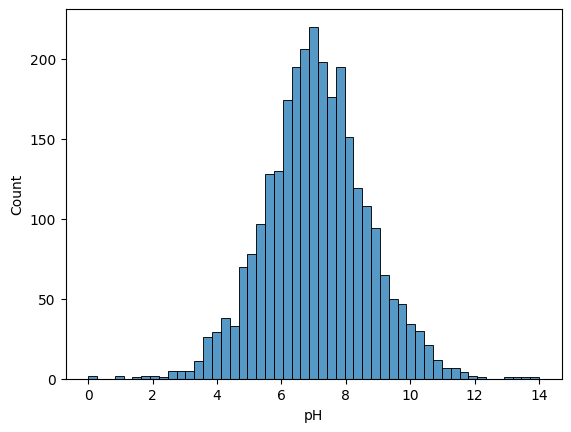

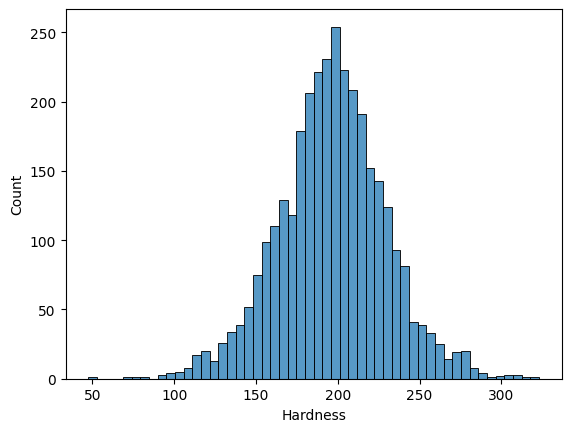

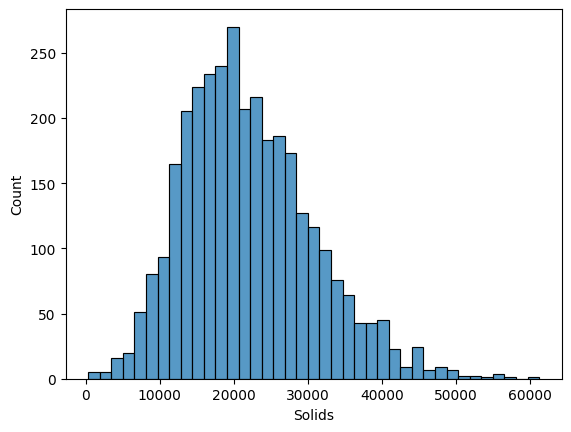

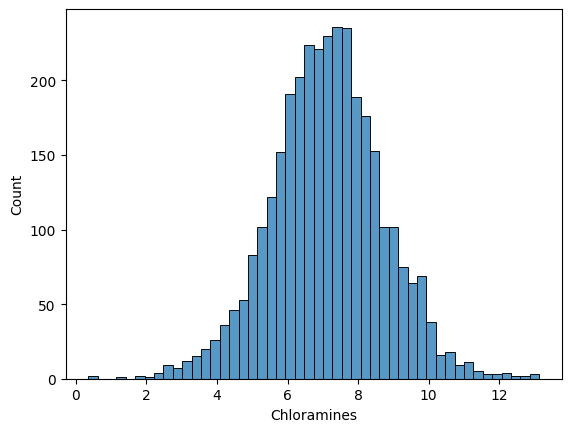

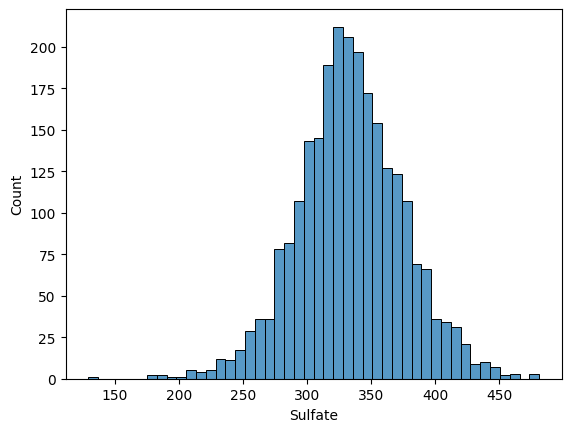

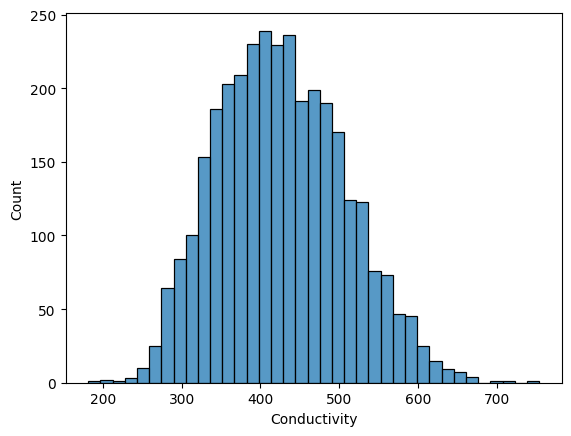

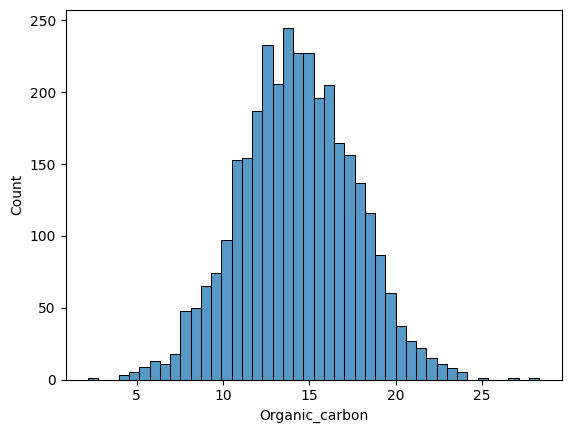

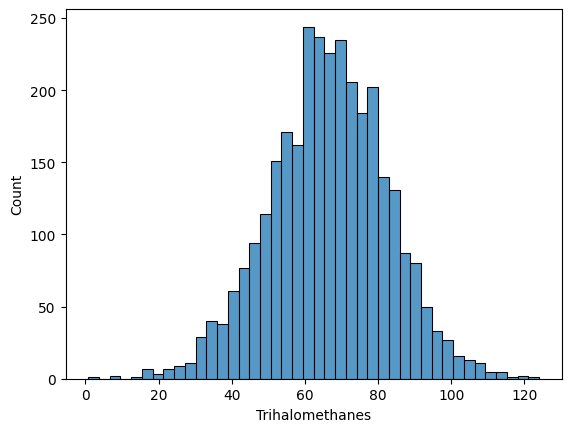

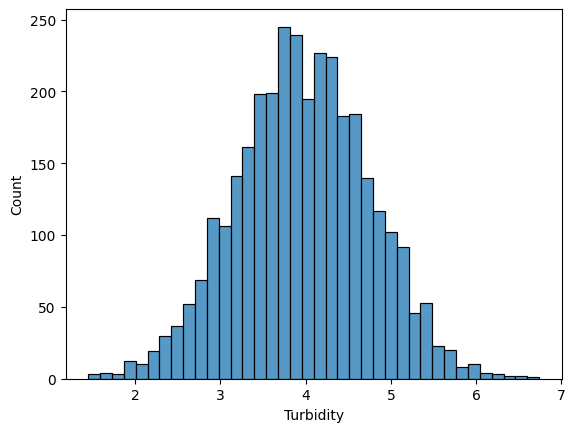

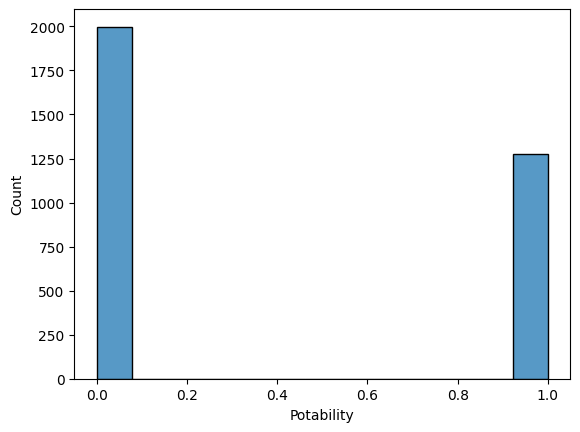

In [6]:
features_tovisualize = features.copy()
for col in features_tovisualize + [target_column]:
    plt.figure()
    sns.histplot(data=df, x=col)

<Axes: ylabel='count'>

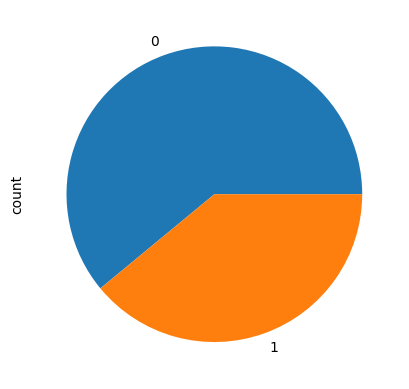

In [7]:
df.Potability.value_counts().plot(kind ='pie')


In [8]:
# Odnos klasa za Potability u procentima
potability_counts = df['Potability'].value_counts(dropna=False).sort_index()
potability_percent = (potability_counts / len(df) * 100).round(2)
display(pd.DataFrame({
    'count': potability_counts,
    'percent': potability_percent
}))

,count,percent
Potability,,
0,1998,60.99
1,1278,39.01


In [9]:
duplicate_rows = df[df.duplicated()]
print("Duplikati:")
print(duplicate_rows)

Duplikati:
Empty DataFrame
Columns: [pH, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity, Potability]
Index: []


## Pregled tipa feature-a

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pH               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Iz ovog mozemo da zakljucimo da nam nije potrebno konvertovanje tipa feature-a iz kategorickih u numericke vrednosti, tako da taj postupak preskacemo. 

## Matrica korelacije - pregled medjusobne zavisnosti kolona

<Axes: >

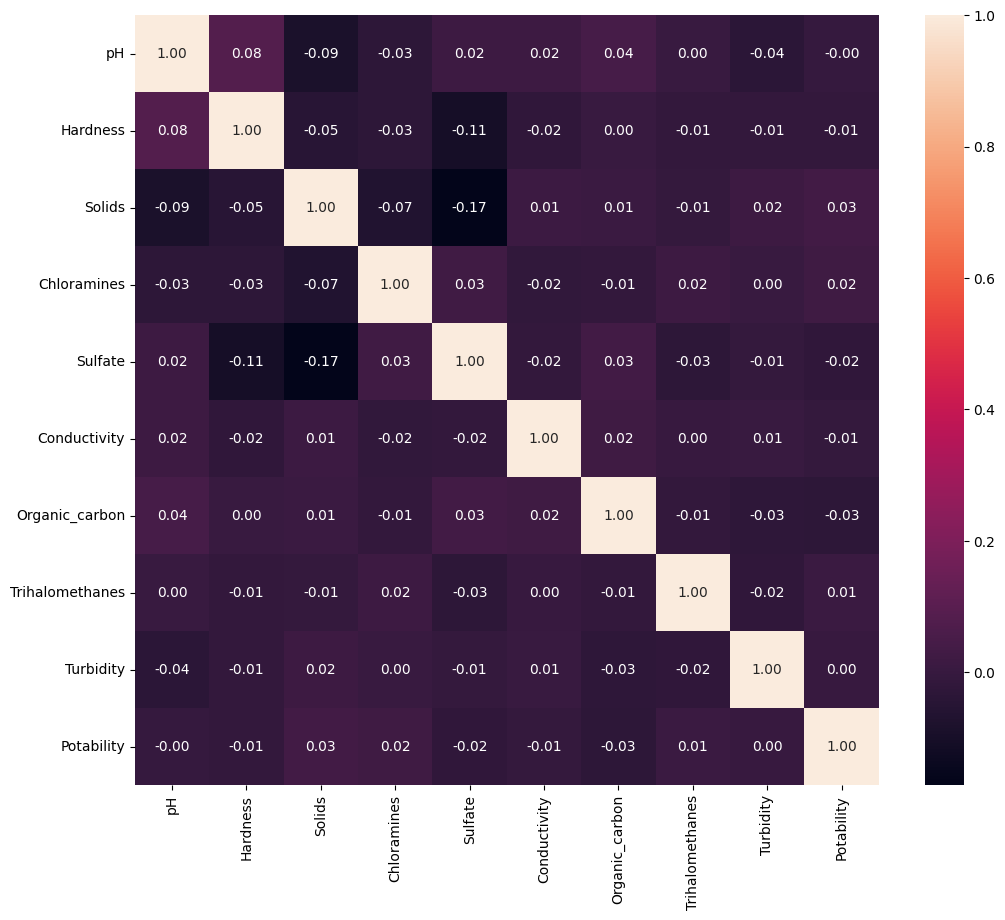

In [11]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f')

Ovde mozemo da vidimo da nijedna kolona nema preveliku korelacioju s ostalim kolonama, osim kolone Solids za koju smo vec rekli da vidimo malo vece odstupanje u opsegu i prosecnom vrednoscu u zavisnosti od toga da li je voda pitka.

## Analiza nedostajucih vrednosti

In [12]:
df.describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


Ovde vidimo da su vrednosti razlicitog opsega za svaku kolonu, tako da ce najverovatnije biti neophodna normalizacija podataka u kasnijim koracima.

In [13]:
df.isnull().sum()

pH                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Mozemo da vidimo da postoje tri kolone koje imaju null vrednosti, i od toga 2/3 kolone deluju kao da su znacajne za ceo dataset sto mozemo da vidimo kasnije, tako da ce handlovanje nedostajucih vrednosti dosta da utice na preciznost celokupnog dataseta.

In [14]:
from sklearn.model_selection import train_test_split

# Split podataka ODMAH nakon učitavanja
# Test set će biti "zaključan" do krajnje evaluacije
df_train, df_test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df[target_column]
)

print("="*70)
print("PODELA PODATAKA NA TRAIN I TEST")
print("="*70)
print(f"Ukupno uzoraka: {len(df)}")
print(f"Train set: {len(df_train)} uzoraka ({len(df_train)/len(df)*100:.1f}%)")
print(f"Test set: {len(df_test)} uzoraka ({len(df_test)/len(df)*100:.1f}%)")
print(f"\nDistribucija klasa u originalnom datasetu:")
print(df[target_column].value_counts())
print(f"\nDistribucija klasa u TRAIN setu:")
print(df_train[target_column].value_counts())
print(f"\nDistribucija klasa u TEST setu:")
print(df_test[target_column].value_counts())
print("="*70)
print("\nOD SADA KORISTIMO SAMO df_train ZA SVE ANALIZE!")
print("df_test je 'zaključan' do krajnjeg testiranja.")
print("="*70)

# Čuvamo test set (ne dirajmo ga do kraja!)
# Sve dalje radimo SAMO sa df_train
df = df_train.copy()

PODELA PODATAKA NA TRAIN I TEST
Ukupno uzoraka: 3276
Train set: 2620 uzoraka (80.0%)
Test set: 656 uzoraka (20.0%)

Distribucija klasa u originalnom datasetu:
Potability
0    1998
1    1278
Name: count, dtype: int64

Distribucija klasa u TRAIN setu:
Potability
0    1598
1    1022
Name: count, dtype: int64

Distribucija klasa u TEST setu:
Potability
0    400
1    256
Name: count, dtype: int64

OD SADA KORISTIMO SAMO df_train ZA SVE ANALIZE!
df_test je 'zaključan' do krajnjeg testiranja.


## Baseline Model 

- Pokazuje koliko je problem tezak "sam po sebi"
- Ako nas finalni model nije mnogo bolji od baseline-a, mozda imamo problem sa podacima ili odabranim pristupom
- DummyClassifier simulira "naivne" strategije (nasumicno pogadjanje, uvek predvidja vecinu, itd.)
- Treniramo modele na sirovim podacima (samo brisemo redove sa null vrednostima zato sto kNN i SVM algoritmi ne mogu da rade sa NaN vrednostima)
- Nema preprocesiranja, normalizacije, niti balansiranja klasa
- Ocekujemo relativno lose rezultate koje cemo kasnije poboljsati   

In [15]:

%pip install -q xgboost
%pip install -q lightgbm

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


df_baseline = df.dropna()
print(f"Baseline dataset: {len(df_baseline)} redova (originalno {len(df)}, uklonjeno {len(df) - len(df_baseline)} redova sa NaN)")

X_baseline = df_baseline.drop(columns=[target_column])
y_baseline = df_baseline[target_column]

baseline_models = {
    'MostFrequent': DummyClassifier(strategy='most_frequent'),
    'Stratified': DummyClassifier(strategy='stratified', random_state=42),
    'Uniform': DummyClassifier(strategy='uniform', random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, verbosity=0),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
    'LGBMClassifier': LGBMClassifier(random_state=42, verbose=-1),
    'CatBoostClassifier': CatBoostClassifier(random_state=42, verbose=0),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=42)
}

# K-Fold Cross-Validation za baseline
kf_baseline = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nBASELINE REZULTATI sirovi podaci bez obrade")
print("=" * 50)
print("\nDummy klasifikatori")
baseline_results_cv = {}
for name, model in baseline_models.items():
    scores = cross_val_score(model, X_baseline, y_baseline, cv=kf_baseline)
    baseline_results_cv[name] = {
        'mean': scores.mean(),
        'std': scores.std()
    }
    # Razdvoji dummy od pravih modela u ispisu
    if name == 'Uniform':
        print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")
    else:
        print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

best_baseline_name = max(baseline_results_cv, key=lambda x: baseline_results_cv[x]['mean'])
best_baseline_acc = 100*baseline_results_cv[best_baseline_name]['mean']
print(f"\nNajbolji baseline: {best_baseline_name} sa {best_baseline_acc:.2f}% tacnoscu")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Baseline dataset: 1607 redova (originalno 2620, uklonjeno 1013 redova sa NaN)

BASELINE REZULTATI sirovi podaci bez obrade

Dummy klasifikatori
MostFrequent: 0.5961 (+/- 0.0144)
Stratified: 0.5115 (+/- 0.0289)
Uniform: 0.4978 (+/- 0.0139)
DecisionTree: 0.5875 (+/- 0.0209)
RandomForest: 0.6684 (+/- 0.0244)
XGBoost: 0.6515 (+/- 0.0183)
ExtraTreesClassifier: 0.6758 (+/- 0.0172)
LGBMClassifier: 0.6503 (+/- 0.0201)
CatBoostClassifier: 0.6833 (+/- 0.0236)
KNN: 0.5619 (+/- 0.0108)
SVM: 0.5961 (+/- 0.0144)

Najbolji baseline: CatBoostClassifier sa 68.33% tacnoscu


Kao sto mozemo da vidimo, tacnost je jako niska. 
Koristili smo DummyClassifier sa vise razlicitih metoda za klasifikaciju dataseta. Dataset nije ni na koji nacin prethodno obradjen, samo sirovi podaci su korisceni sa nebalansiranim, nenormalizovanim datasetom.

In [16]:

df[df['Potability']==0].isnull().sum()

pH                 246
Hardness             0
Solids               0
Chloramines          0
Sulfate            393
Conductivity         0
Organic_carbon       0
Trihalomethanes     90
Turbidity            0
Potability           0
dtype: int64

In [17]:
df[df['Potability']==1].isnull().sum()

pH                 141
Hardness             0
Solids               0
Chloramines          0
Sulfate            232
Conductivity         0
Organic_carbon       0
Trihalomethanes     44
Turbidity            0
Potability           0
dtype: int64

                 count  percent
pH                 387    14.77
Hardness             0     0.00
Solids               0     0.00
Chloramines          0     0.00
Sulfate            625    23.85
Conductivity         0     0.00
Organic_carbon       0     0.00
Trihalomethanes    134     5.11
Turbidity            0     0.00
Potability           0     0.00
Uzoraka sa bar jednim NaN: 1013
Uzoraka bez NaN: 1607


,count,percent
Potability,,
0,640,63.18
1,373,36.82


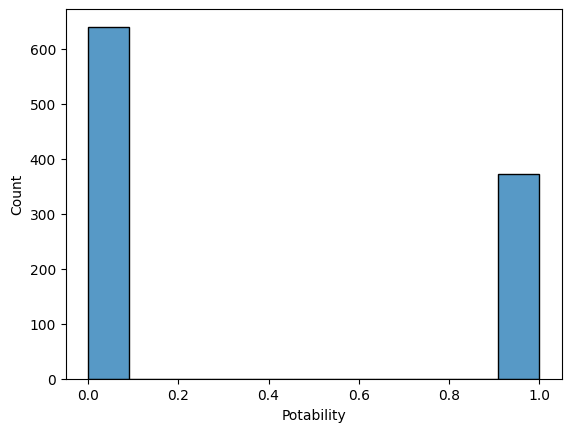

In [18]:
null_counts = df.isnull().sum()
null_percent = (null_counts / len(df) * 100).round(2)
print(pd.DataFrame({
    'count': null_counts,
    'percent': null_percent
}))
only_with_nulls = df[df.isnull().any(axis=1)]
print(f"Uzoraka sa bar jednim NaN: {len(only_with_nulls)}")
plt.figure()
sns.histplot(data=only_with_nulls, x='Potability')

print("Uzoraka bez NaN:", len(df.dropna()))

# Odnos klasa za Potability u procentima
potability_counts = only_with_nulls['Potability'].value_counts(dropna=False).sort_index()
potability_percent = (potability_counts / len(only_with_nulls) * 100).round(2)
display(pd.DataFrame({
    'count': potability_counts,
    'percent': potability_percent
}))

S obzirom da odnos broja redova u odnosu na parametar Pitkost nije pormenila u odnosu na celokupan skup. Mozemo da zakljucimo da su NaN vrednosti skoro isto zastupljene u obe kategorije.

In [ ]:
# Duploraj redove koje nemaju NaN vrednost i Portable=1
#df_imbalanced_added = df[(df['Potability'] == 1) & (df.notnull().all(axis=1))]
#df_imbalanced = df.copy()
#df_imbalanced = pd.concat([df_imbalanced, df_imbalanced_added], ignore_index=True)

#df = df_imbalanced.copy()
#print(f"Nakon dupliranja pozitivnih uzoraka bez NaN: {len(df_imbalanced)} uzoraka")

Nakon dupliranja pozitivnih uzoraka bez NaN: 3269 uzoraka


## Brisanje redova koji imaju sve tri prazne kolone 

In [ ]:
rows_with_multiple_nulls = df[df.isnull().sum(axis=1) == 3]

print("Redovi sa tri null kolona:")
rows_with_multiple_nulls.describe()

Redovi sa tri null kolona:


,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,0.0,8.000000,8.000000,8.000000,0.0,8.000000,8.000000,0.0,8.000000,8.000000
mean,NaN,193.596073,23018.624407,7.070402,NaN,448.215684,13.707968,NaN,3.805665,0.125000
std,NaN,28.036645,12475.721706,1.333442,NaN,102.469818,2.804555,NaN,0.604967,0.353553
min,NaN,143.300200,11954.700730,4.963124,NaN,293.477998,10.717588,NaN,3.017985,0.000000
25%,NaN,180.591830,15327.148264,6.194290,NaN,380.775344,12.390864,NaN,3.409320,0.000000
50%,NaN,197.585562,18770.863766,7.081072,NaN,451.773737,12.947796,NaN,3.756137,0.000000
75%,NaN,212.553787,25694.204085,7.869322,NaN,539.745090,14.221886,NaN,4.018802,0.000000
max,NaN,226.765646,44982.734155,8.898024,NaN,566.339294,19.585497,NaN,4.863378,1.000000


Vidimo da imamo 9 redova koji imaju te tri kolone sa null vrednostima, tako da brisanje istih nece mnogo da utice na celokupan dataset.

In [ ]:
rows_with_multiple_nulls = df[df.isnull().sum(axis=1) >= 2]
print("Redovi sa dve null kolona:")
rows_with_multiple_nulls.describe()

# Prikaz redova sa vise od 2 null vrednosti u osnosu na Potability pomocu odgovarajuceg grafikona 

#rows_with_multiple_nulls.groupby('Potability').size()


Redovi sa dve null kolona:


,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,27.000000,125.000000,125.000000,125.000000,12.000000,125.000000,125.000000,78.000000,125.000000,125.000000
mean,7.417456,194.366629,21490.661348,7.187526,348.471947,413.569243,14.471145,65.682017,3.936376,0.344000
std,1.709134,30.797061,8798.282924,1.574345,63.989515,72.582267,3.100252,17.190709,0.781069,0.476953
min,4.059431,103.464759,4142.499001,2.750837,234.285621,274.696540,7.070771,18.400012,1.659799,0.000000
25%,6.428889,181.080656,14563.682649,6.362889,318.878290,360.814296,12.167905,56.229357,3.365174,0.000000
50%,7.499845,194.806091,20944.620814,7.317570,338.769303,414.101567,14.134954,67.070220,3.878664,0.000000
75%,8.299979,214.216060,26492.716181,8.272940,386.918311,464.184606,16.657294,75.808563,4.407566,1.000000
max,10.851860,287.370208,44982.734155,11.251507,462.474215,599.614535,22.469892,118.357275,6.204846,1.000000


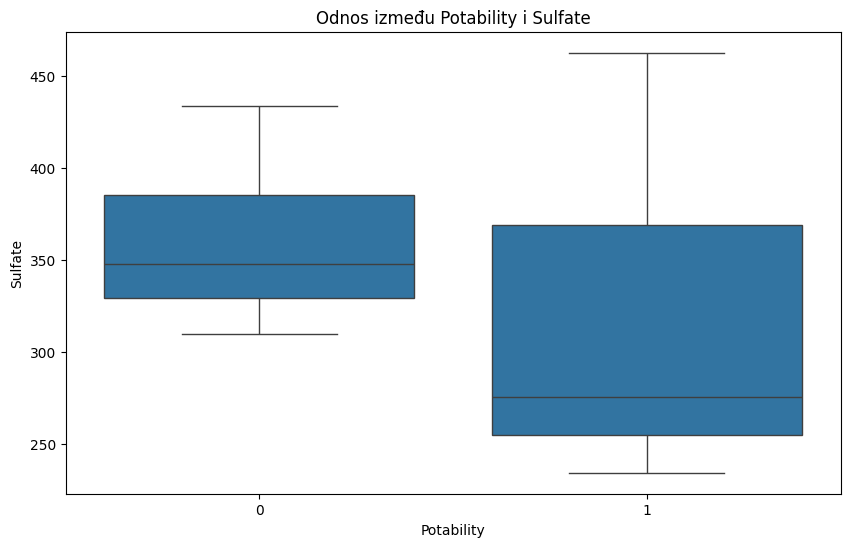

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=rows_with_multiple_nulls, x='Potability', y='Sulfate')
plt.title('Odnos između Potability i Sulfate')
plt.xlabel('Potability')
plt.ylabel('Sulfate')
plt.show()


# plt.figure(figsize=(10, 6))
# sns.violinplot(data=rows_with_multiple_nulls, x='Potability', y='Sulfate')
# plt.title('Odnos između Potability i Sulfate')
# plt.show()



In [ ]:
# Test different thresholds for removing rows with NaN values
print("=" * 70)
print("POREĐENJE RAZLIČITIH PRAGOVA ZA BRISANJE REDOVA SA NaN")
print("=" * 70)

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score

comparison_results = []

for threshold in [1, 2, 3]:
    # Get rows with >= threshold NaN values
    rows_to_drop = df[df.isnull().sum(axis=1) >= threshold]
    df_filtered = df.drop(rows_to_drop.index)
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    df_filtered_copy = df_filtered.copy()
    df_filtered_copy.iloc[:, :-1] = imputer.fit_transform(df_filtered_copy.iloc[:, :-1])
    
    print(f"\n--- Prag: >= {threshold} NaN vrednosti ---")
    print(f"Redovi izbrisani: {len(rows_to_drop)} ({100*len(rows_to_drop)/len(df):.1f}%)")
    print(f"Preostali redovi: {len(df_filtered)} ({100*len(df_filtered)/len(df):.1f}%)")
    
    X = df_filtered_copy.drop(columns=['Potability'])
    y = df_filtered_copy['Potability']
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    models = {
        'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
        'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    }
    
    # Define scoring metrics
    scoring_metrics = {
        'Accuracy': 'accuracy',
        'F1': make_scorer(f1_score, zero_division=0),
        'Precision': make_scorer(precision_score, zero_division=0),
        'Recall': make_scorer(recall_score, zero_division=0),
        'ROC-AUC': 'roc_auc'
    }
    
    for model_name, model in models.items():
        # Cross-validation sa svim metrikama
        cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring_metrics, return_train_score=False)
        
        print(f"\n  {model_name}:")
        for metric_name in scoring_metrics.keys():
            scores = cv_results[f'test_{metric_name}']
            print(f"    {metric_name:12} | Mean: {scores.mean():.4f} (+/- {scores.std():.4f})")
            
            comparison_results.append({
                'Prag': threshold,
                'Model': model_name,
                'Metrika': metric_name,
                'Vrednost': scores.mean(),
                'Std': scores.std(),
                'Redova_izbrisano': len(rows_to_drop)
            })

print("\n" + "=" * 70)
comparison_df = pd.DataFrame(comparison_results)
print("\nSUMARNI PRIKAZ - METRIKE:")
print(comparison_df.to_string(index=False))

# Create pivot table for better visualization
print("\n" + "=" * 70)
print("\nPIVOT TABELA - ACCURACY:")
pivot_acc = comparison_df[comparison_df['Metrika'] == 'Accuracy'].pivot_table(
    index='Model', columns='Prag', values='Vrednost', aggfunc='first'
)
print(pivot_acc.round(4))

print("\n" + "=" * 70)
print("\nPIVOT TABELA - F1 SCORE:")
pivot_f1 = comparison_df[comparison_df['Metrika'] == 'F1'].pivot_table(
    index='Model', columns='Prag', values='Vrednost', aggfunc='first'
)
print(pivot_f1.round(4))

POREĐENJE RAZLIČITIH PRAGOVA ZA BRISANJE REDOVA SA NaN

--- Prag: >= 1 NaN vrednosti ---
Redovi izbrisani: 1013 (31.0%)
Preostali redovi: 2256 (69.0%)

  CatBoost:
    Accuracy     | Mean: 0.7877 (+/- 0.0126)
    F1           | Mean: 0.8320 (+/- 0.0099)
    Precision    | Mean: 0.7638 (+/- 0.0112)
    Recall       | Mean: 0.9137 (+/- 0.0141)
    ROC-AUC      | Mean: 0.8642 (+/- 0.0129)

  RandomForest:
    Accuracy     | Mean: 0.8120 (+/- 0.0116)
    F1           | Mean: 0.8505 (+/- 0.0084)
    Precision    | Mean: 0.7844 (+/- 0.0139)
    Recall       | Mean: 0.9291 (+/- 0.0132)
    ROC-AUC      | Mean: 0.9370 (+/- 0.0094)

--- Prag: >= 2 NaN vrednosti ---
Redovi izbrisani: 125 (3.8%)
Preostali redovi: 3144 (96.2%)

  CatBoost:
    Accuracy     | Mean: 0.7430 (+/- 0.0094)
    F1           | Mean: 0.7523 (+/- 0.0098)
    Precision    | Mean: 0.7511 (+/- 0.0115)
    Recall       | Mean: 0.7537 (+/- 0.0177)
    ROC-AUC      | Mean: 0.8183 (+/- 0.0073)

  RandomForest:
    Accuracy     | M

Kada se uporede verdnosti dobijene uklanjenjem redova sa vise od 3 NaN verdnosti, i sa vise od 2 NaN, i basemodel, mozemo da zaklju;imo da najbolji rezultart daje opcija sa uklanjnjem redova sa 3 NaN vrednosti 

In [ ]:
# Detaljne tabele za svaku metriku
print("\n" + "=" * 70)
print("DETALJNE TABELE ZA SVE METRIKE")
print("=" * 70)

for metric in ['Accuracy', 'F1', 'Precision', 'Recall', 'ROC-AUC']:
    print(f"\n{'=' * 70}")
    print(f"  {metric.upper()}")
    print(f"{'=' * 80}")
    
    metric_data = comparison_df[comparison_df['Metrika'] == metric].copy()
    metric_data['Vrednost'] = metric_data['Vrednost'].round(4)
    metric_data['Std'] = metric_data['Std'].round(4)
    
    pivot_display = metric_data.pivot_table(
        index='Model',
        columns='Prag',
        values=['Vrednost', 'Std'],
        aggfunc='first'
    )
    
    # Flatten the multi-index columns for better readability
    for prag in [1, 2, 3]:
        print(f"\n  Prag: >= {prag} NaN vrednosti")
        for model in metric_data['Model'].unique():
            data = metric_data[(metric_data['Model'] == model) & (metric_data['Prag'] == prag)]
            if len(data) > 0:
                row = data.iloc[0]
                print(f"    {model:15} | {row['Vrednost']:.4f} ± {row['Std']:.4f}")


DETALJNE TABELE ZA SVE METRIKE

  ACCURACY

  Prag: >= 1 NaN vrednosti
    CatBoost        | 0.7877 ± 0.0126
    RandomForest    | 0.8120 ± 0.0116

  Prag: >= 2 NaN vrednosti
    CatBoost        | 0.7430 ± 0.0094
    RandomForest    | 0.7878 ± 0.0150

  Prag: >= 3 NaN vrednosti
    CatBoost        | 0.7430 ± 0.0154
    RandomForest    | 0.7795 ± 0.0093

  F1

  Prag: >= 1 NaN vrednosti
    CatBoost        | 0.8320 ± 0.0099
    RandomForest    | 0.8505 ± 0.0084

  Prag: >= 2 NaN vrednosti
    CatBoost        | 0.7523 ± 0.0098
    RandomForest    | 0.7936 ± 0.0159

  Prag: >= 3 NaN vrednosti
    CatBoost        | 0.7466 ± 0.0152
    RandomForest    | 0.7837 ± 0.0097

  PRECISION

  Prag: >= 1 NaN vrednosti
    CatBoost        | 0.7638 ± 0.0112
    RandomForest    | 0.7844 ± 0.0139

  Prag: >= 2 NaN vrednosti
    CatBoost        | 0.7511 ± 0.0115
    RandomForest    | 0.7994 ± 0.0126

  Prag: >= 3 NaN vrednosti
    CatBoost        | 0.7543 ± 0.0180
    RandomForest    | 0.7873 ± 0.0081



In [ ]:

rows_with_multiple_nulls = df[df.isnull().sum(axis=1) >= 2]
#df = df.drop(rows_with_multiple_nulls.index)

In [ ]:
df.isnull().sum()

pH                 387
Hardness             0
Solids               0
Chloramines          0
Sulfate            625
Conductivity         0
Organic_carbon       0
Trihalomethanes    134
Turbidity            0
Potability           0
dtype: int64

## Imputiranje praznih vrednosti 

### Metoda imputacije: Mean po grupama (Group Mean Imputation)

U nasem slucaju, hemijske karakteristike vode se razlikuju u zavisnosti od toga da li je voda pitka ili ne. Na primer, pitka voda ima drugaciji prosecni pH od nepitke. Zato grupno imputiranje (po Potability klasi) bolje cuva prirodnu strukturu podataka.
Ova metoda se kasnije pokazala kao najefektivnija za preciznost modela.

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans

# Ucitaj sirove podatke (sa NaN vrednostima)
df_raw = df.copy()

# Grupna mean imputacija (po Potability)
df_group = df_raw.copy()
for col in ['pH', 'Sulfate', 'Trihalomethanes']:
    df_group[col] = df_group[col].fillna(df_group.groupby('Potability')[col].transform('mean'))


# Grupna mean imputacija (po Potability)
df_ziro = df_raw.copy()
for col in ['pH', 'Sulfate', 'Trihalomethanes']:
    df_ziro[col] = df_ziro[col].fillna(0)

# KNN imputacija
df_knn = df_raw.copy()
imputer_knn = KNNImputer(n_neighbors=5)
df_knn[df_knn.columns[:-1]] = imputer_knn.fit_transform(df_knn[df_knn.columns[:-1]])
# Iterative Imputer (MICE)

df_mice = df_raw.copy()
imputer_mice = IterativeImputer(random_state=42, max_iter=10)
df_mice[df_mice.columns[:-1]] = imputer_mice.fit_transform(df_mice[df_mice.columns[:-1]])

# KMeans clustering-based imputation

df_kmeans = df_raw.copy()
# Separate features with and without NaN
cols_with_nan = ['pH', 'Sulfate', 'Trihalomethanes']
cols_without_nan = [col for col in df_kmeans.columns[:-1] if col not in cols_with_nan]

# Fit KMeans on complete features
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_complete = df_kmeans[cols_without_nan].values
clusters = kmeans.fit_predict(df_complete)
df_kmeans['cluster'] = clusters

# Impute missing values with cluster mean
for col in cols_with_nan:
    df_kmeans[col] = df_kmeans.groupby('cluster')[col].transform(
        lambda x: x.fillna(x.mean())
    )

df_kmeans = df_kmeans.drop(columns=['cluster'])

# Uporedna evaluacija
clear_preprocessing_results()
print("=== Grupna mean imputacija ===")
evaluate_models_after_step(df_group, "Imputacija: Group Mean", compare_scalers=False)

print("\n=== Grupna zero imputacija ===")
evaluate_models_after_step(df_ziro, "Imputacija: Group Zero", compare_scalers=False)

print("\n=== KNN imputacija ===")
evaluate_models_after_step(df_knn, "Imputacija: KNN", compare_scalers=False)

print("\n=== MICE imputacija ===")
evaluate_models_after_step(df_mice, "Imputacija: MICE", compare_scalers=False)

print("\n=== KMeans clustering-based imputacija ===")
evaluate_models_after_step(df_kmeans, "Imputacija: KMeans", compare_scalers=False)

=== Grupna mean imputacija ===

EVALUACIJA: Imputacija: Group Mean
Dataset: 3269 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1598), 1: np.int64(1671)}
  DecisionTree       | Accuracy: 0.8452 (+/- 0.0048)
  RandomForest       | Accuracy: 0.8740 (+/- 0.0071)
  ExtraTrees         | Accuracy: 0.8449 (+/- 0.0151)
  XGBoost            | Accuracy: 0.8694 (+/- 0.0128)
  LightGBM           | Accuracy: 0.8654 (+/- 0.0034)
  CatBoost           | Accuracy: 0.8446 (+/- 0.0101)
  KNN                | Accuracy: 0.6387 (+/- 0.0117)
  SVM                | Accuracy: 0.6730 (+/- 0.0109)

  NAJBOLJI: RandomForest (0.8740)
Step             Imputacija: Group Mean
Model                      RandomForest
Accuracy_Mean                   0.87397
Accuracy_Std                   0.007112
F1                             0.883772
Recall                         0.937167
Precision                       0.83628
Name: 1, dtype: object

=== Grupna zero imputacija ===

EVALUACIJA: Imputacija: Group Zero
Dataset: 32

KeyboardInterrupt: 

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

df_group_m = df.copy()
df_group_m = pd.DataFrame(
    imputer.fit_transform(df_group_m),
    columns=df.columns
)
    
clear_preprocessing_results()
print("=== Grupna median imputacija ===")
evaluate_models_after_step(df_group_m, "Imputacija: Group Median", compare_scalers=False)

=== Grupna median imputacija ===

EVALUACIJA: Imputacija: Group Median
Dataset: 4442 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1516), 1: np.int64(2926)}
  DecisionTree       | Accuracy: 0.8962 (+/- 0.0068)
  RandomForest       | Accuracy: 0.9027 (+/- 0.0024)
  ExtraTrees         | Accuracy: 0.9032 (+/- 0.0064)
  XGBoost            | Accuracy: 0.9030 (+/- 0.0085)
  LightGBM           | Accuracy: 0.8841 (+/- 0.0051)
  CatBoost           | Accuracy: 0.8706 (+/- 0.0097)
  KNN                | Accuracy: 0.7276 (+/- 0.0021)
  SVM                | Accuracy: 0.7303 (+/- 0.0087)

  NAJBOLJI: ExtraTrees (0.9032)
Step             Imputacija: Group Median
Model                          ExtraTrees
Accuracy_Mean                    0.903196
Accuracy_Std                     0.006385
F1                               0.926165
Recall                           0.922076
Precision                          0.9304
Name: 2, dtype: object


=== Grupna median imputacija ===

EVALUACIJA: Imputacija: Group Median
Dataset: 4442 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1516), 1: np.int64(2926)}
  DecisionTree       | Accuracy: 0.8962 (+/- 0.0068)
  RandomForest       | Accuracy: 0.9027 (+/- 0.0024)
  ExtraTrees         | Accuracy: 0.9032 (+/- 0.0064)
  XGBoost            | Accuracy: 0.9030 (+/- 0.0085)
  LightGBM           | Accuracy: 0.8841 (+/- 0.0051)
  CatBoost           | Accuracy: 0.8706 (+/- 0.0097)
  KNN                | Accuracy: 0.7276 (+/- 0.0021)
  SVM                | Accuracy: 0.7303 (+/- 0.0087)

  NAJBOLJI: ExtraTrees (0.9032)
Step             Imputacija: Group Median
Model                          ExtraTrees
Accuracy_Mean                    0.903196
Accuracy_Std                     0.006385
F1                               0.926165
Recall                           0.922076
Precision                          0.9304
Name: 2, dtype: object


,Step,Model,Accuracy_Mean,Accuracy_Std,F1,Recall,Precision
0,Imputacija: Group Median,DecisionTree,0.896217,0.006818,0.925629,0.980527,0.876704
1,Imputacija: Group Median,RandomForest,0.902746,0.002432,0.930571,0.989406,0.878364
2,Imputacija: Group Median,ExtraTrees,0.903196,0.006385,0.926165,0.922076,0.930400
3,Imputacija: Group Median,XGBoost,0.902973,0.008487,0.931074,0.994189,0.875628
4,Imputacija: Group Median,LightGBM,0.884061,0.005146,0.918770,0.995215,0.853279
5,Imputacija: Group Median,CatBoost,0.870551,0.009693,0.910083,0.993850,0.839466
6,Imputacija: Group Median,KNN,0.727600,0.002140,0.808695,0.874232,0.752453
7,Imputacija: Group Median,SVM,0.730298,0.008694,0.823991,0.958305,0.722766


In [ ]:
df['pH']=df['pH'].fillna(df.groupby(['Potability'])['pH'].transform('median'))
df['Sulfate']=df['Sulfate'].fillna(df.groupby(['Potability'])['Sulfate'].transform('median'))

# Procenat nedostajajucih vrednosti je oko 5%
#df_imputed = df.copy()
df['Trihalomethanes']=df['Trihalomethanes'].fillna(df.groupby(['Potability'])['Trihalomethanes'].transform('median'))

In [ ]:
from sklearn.impute import SimpleImputer, KNNImputer

# Imputacija pH kolone sa median strategijom i dodavanjem indikatora
#imputer_ph = SimpleImputer(strategy='median', add_indicator=True)
#df_ph_imputed = imputer_ph.fit_transform(df[['pH']])

# Imputacija Sulfate kolone sa KNN imputerom
#imputer_sulfate = KNNImputer(n_neighbors=5)
#df_sulfate_imputed = imputer_sulfate.fit_transform(df[['Sulfate']])

# Zamena originalnnih kolona sa imputiranim vrednostima
#df_imputed['pH'] = df_ph_imputed[:, 0]
#df_imputed['Sulfate'] = df_sulfate_imputed[:, 0]

# Provera da li ima jos NaN vrednosti
#print("Preostale NaN vrednosti:")
#print(df_imputed.isnull().sum())

Preostale NaN vrednosti:
pH                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


In [ ]:
#imputer = SimpleImputer(strategy='median', add_indicator=True)
#df_imputed = imputer.fit_transform(df_imputed[['Sulfate']])

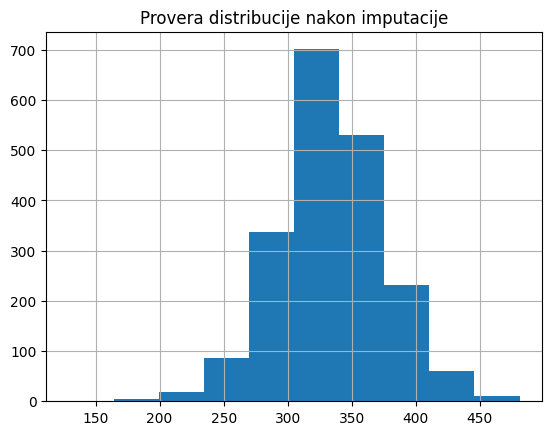

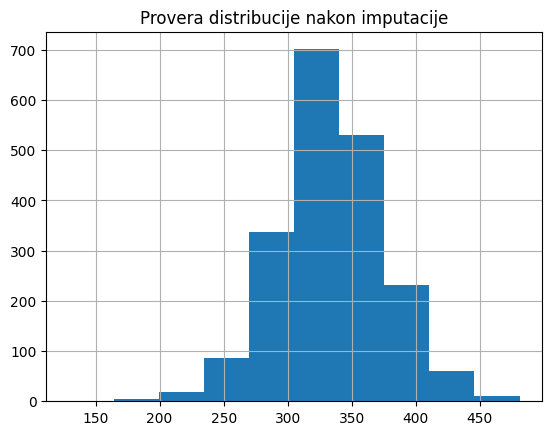

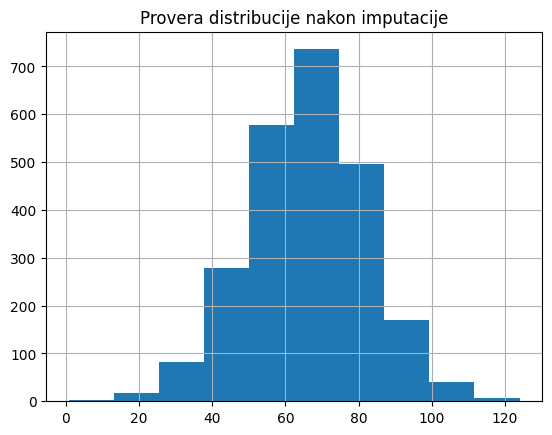

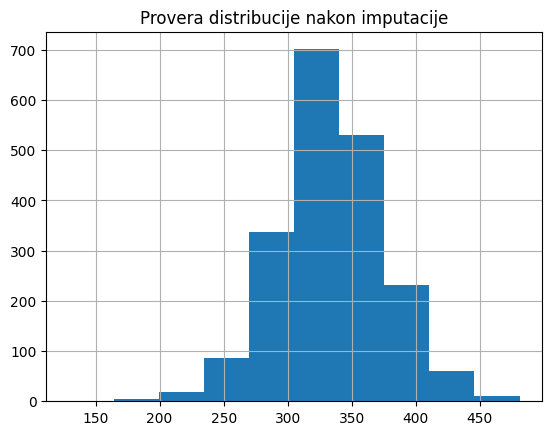

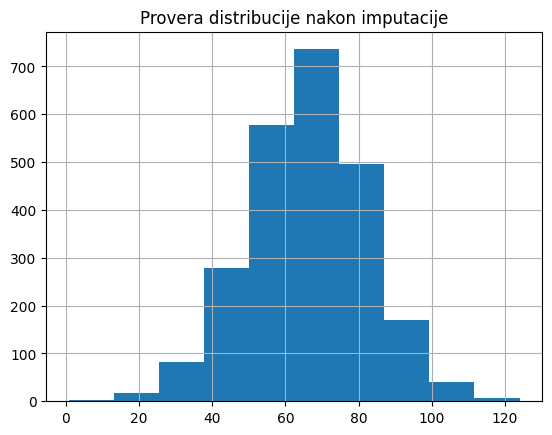

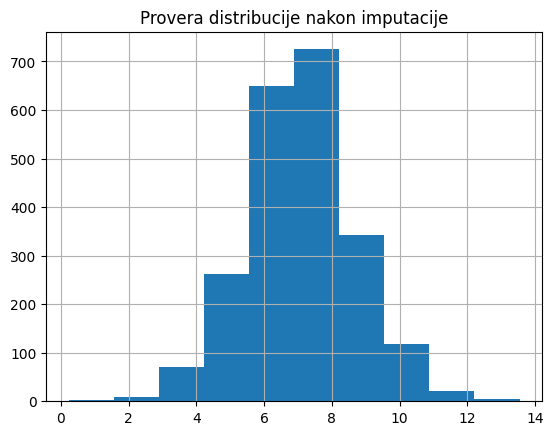

In [ ]:
import matplotlib.pyplot as plt

for col in ['Sulfate', 'Trihalomethanes', 'pH']:
    df[col].hist()
    plt.title("Provera distribucije nakon imputacije")
    plt.show()

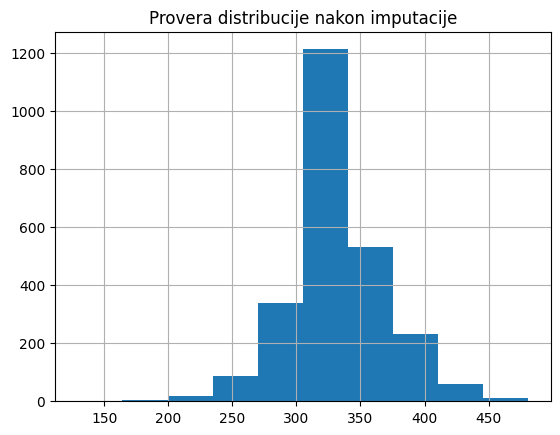

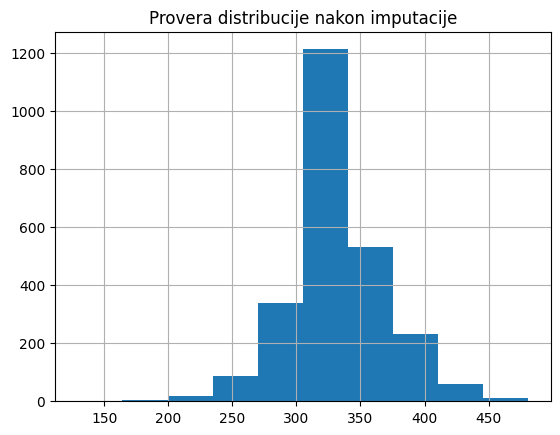

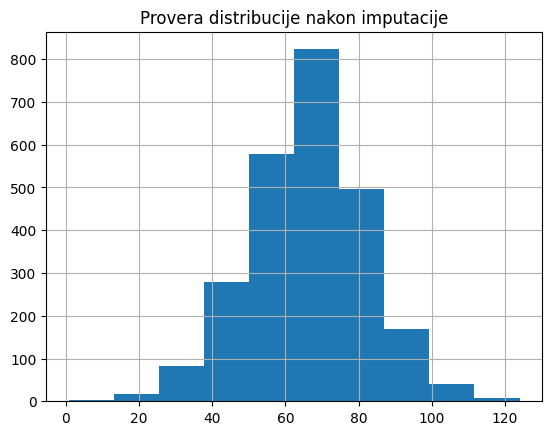

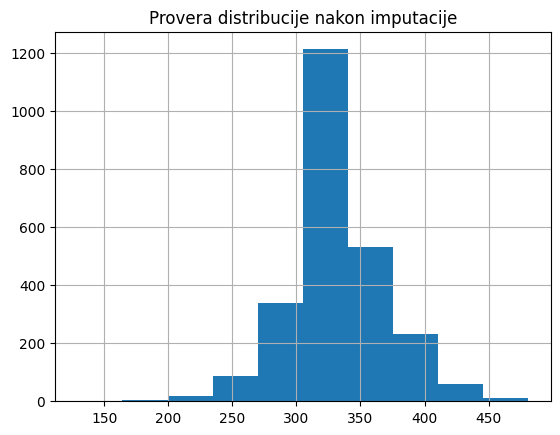

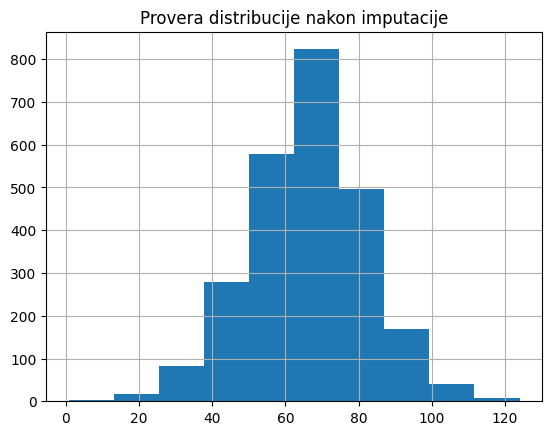

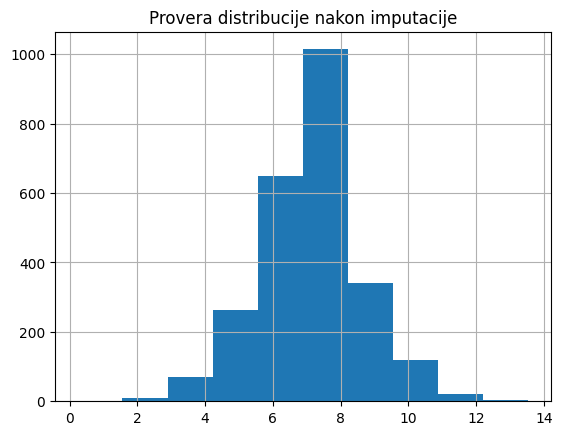

In [ ]:
for col in ['Sulfate', 'Trihalomethanes', 'pH']:
    df_imputed[col].hist()
    plt.title("Provera distribucije nakon imputacije")
    plt.show()

In [ ]:
df = df_imputed.copy()

In [ ]:
clear_preprocessing_results()
evaluate_models_after_step(df, "2. Nakon imputacije", compare_scalers=False)


EVALUACIJA: 2. Nakon imputacije
Dataset: 4442 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1516), 1: np.int64(2926)}
  DecisionTree       | Accuracy: 0.8962 (+/- 0.0068)
  RandomForest       | Accuracy: 0.9027 (+/- 0.0024)
  ExtraTrees         | Accuracy: 0.9032 (+/- 0.0064)
  XGBoost            | Accuracy: 0.9030 (+/- 0.0085)
  LightGBM           | Accuracy: 0.8841 (+/- 0.0051)
  CatBoost           | Accuracy: 0.8706 (+/- 0.0097)
  KNN                | Accuracy: 0.7276 (+/- 0.0021)
  SVM                | Accuracy: 0.7303 (+/- 0.0087)

  NAJBOLJI: ExtraTrees (0.9032)
Step             2. Nakon imputacije
Model                     ExtraTrees
Accuracy_Mean               0.903196
Accuracy_Std                0.006385
F1                          0.926165
Recall                      0.922076
Precision                     0.9304
Name: 2, dtype: object



EVALUACIJA: 2. Nakon imputacije
Dataset: 4442 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1516), 1: np.int64(2926)}
  DecisionTree       | Accuracy: 0.8962 (+/- 0.0068)
  RandomForest       | Accuracy: 0.9027 (+/- 0.0024)
  ExtraTrees         | Accuracy: 0.9032 (+/- 0.0064)
  XGBoost            | Accuracy: 0.9030 (+/- 0.0085)
  LightGBM           | Accuracy: 0.8841 (+/- 0.0051)
  CatBoost           | Accuracy: 0.8706 (+/- 0.0097)
  KNN                | Accuracy: 0.7276 (+/- 0.0021)
  SVM                | Accuracy: 0.7303 (+/- 0.0087)

  NAJBOLJI: ExtraTrees (0.9032)
Step             2. Nakon imputacije
Model                     ExtraTrees
Accuracy_Mean               0.903196
Accuracy_Std                0.006385
F1                          0.926165
Recall                      0.922076
Precision                     0.9304
Name: 2, dtype: object


,Step,Model,Accuracy_Mean,Accuracy_Std,F1,Recall,Precision
0,2. Nakon imputacije,DecisionTree,0.896217,0.006818,0.925629,0.980527,0.876704
1,2. Nakon imputacije,RandomForest,0.902746,0.002432,0.930571,0.989406,0.878364
2,2. Nakon imputacije,ExtraTrees,0.903196,0.006385,0.926165,0.922076,0.930400
3,2. Nakon imputacije,XGBoost,0.902973,0.008487,0.931074,0.994189,0.875628
4,2. Nakon imputacije,LightGBM,0.884061,0.005146,0.918770,0.995215,0.853279
5,2. Nakon imputacije,CatBoost,0.870551,0.009693,0.910083,0.993850,0.839466
6,2. Nakon imputacije,KNN,0.727600,0.002140,0.808695,0.874232,0.752453
7,2. Nakon imputacije,SVM,0.730298,0.008694,0.823991,0.958305,0.722766


In [ ]:
df.isnull().sum()

pH                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

Kao sto vidimo, vrednosti su uspesno popunjene i vise nemamo praznih kolona. Sada mozemo da vidimo kako izgledaju podaci u zavisnosti od ciljne kolone - Potability.

In [ ]:
df[df['Potability']==0].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1516.000000,1516.000000,1516.000000,1516.000000,1516.000000,1516.000000,1516.000000,1516.000000,1516.000000,1516.0
mean,7.064325,196.540774,21665.765632,7.090117,334.071358,428.532253,14.298233,66.119704,3.973251,0.0
std,1.569679,30.716773,8485.928412,1.516993,32.507152,80.277228,3.313069,15.721537,0.783409,0.0
min,1.431782,98.452931,320.942611,1.683993,203.444521,181.483754,4.371899,0.738000,1.496101,0.0
25%,6.153241,177.728978,15596.974568,6.162264,317.255384,370.206003,12.051558,55.946083,3.443652,0.0
50%,7.016836,196.579505,20717.105061,7.093001,333.133897,425.220218,14.215791,66.188642,3.978840,0.0
75%,7.969025,215.456317,26844.760234,8.070924,348.889097,482.349100,16.537357,76.384443,4.498478,0.0
max,13.541240,300.292476,61227.196008,12.653362,460.107069,753.342620,27.006707,120.030077,6.739000,0.0


In [ ]:
df[df['Potability']==1].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.0
mean,7.140017,196.850024,22224.616308,7.157380,333.396337,427.926947,14.284220,66.306417,3.991592,1.0
std,1.419466,35.338744,8983.899545,1.738956,46.429569,82.743390,3.267235,16.265963,0.768138,0.0
min,0.227499,47.432000,728.750830,0.352000,129.000000,217.358330,2.200000,8.175876,1.492207,1.0
25%,6.300002,175.789558,15597.640883,6.062561,305.554444,364.931128,12.097920,55.401113,3.438465,1.0
50%,7.063647,198.412447,21153.322827,7.156738,333.067652,424.791249,14.252791,66.674658,4.007347,1.0
75%,7.964889,218.261170,27411.679342,8.175744,364.458497,489.545055,16.559191,77.166619,4.515150,1.0
max,13.175402,323.124000,56488.672413,13.043806,481.030642,695.369528,23.604298,124.000000,6.226580,1.0


In [ ]:
df.groupby('Potability').median().T

Potability,0,1
pH,7.016836,7.063647
Hardness,196.579505,198.412447
Solids,20717.105061,21153.322827
Chloramines,7.093001,7.156738
Sulfate,333.133897,333.067652
Conductivity,425.220218,424.791249
Organic_carbon,14.215791,14.252791
Trihalomethanes,66.188642,66.674658
Turbidity,3.978840,4.007347


In [ ]:
df.groupby('Potability').mean().T

Potability,0,1
pH,7.064325,7.140017
Hardness,196.540774,196.850024
Solids,21665.765632,22224.616308
Chloramines,7.090117,7.157380
Sulfate,334.071358,333.396337
Conductivity,428.532253,427.926947
Organic_carbon,14.298233,14.284220
Trihalomethanes,66.119704,66.306417
Turbidity,3.973251,3.991592


Iz ovih podataka mozemo da uocimo da dataset nije balansiran, postoje vise slogova gde je voda oznacena kao nepitka, a i sam raspon vrednosti se razlikuje, pogotovo za kolonu Solids i Hardness. Sada mozemo da kreiramo i matricu korelacije da vidimo koja je medjusobna zavinost svih tih kolona:

<Axes: >

<Axes: >

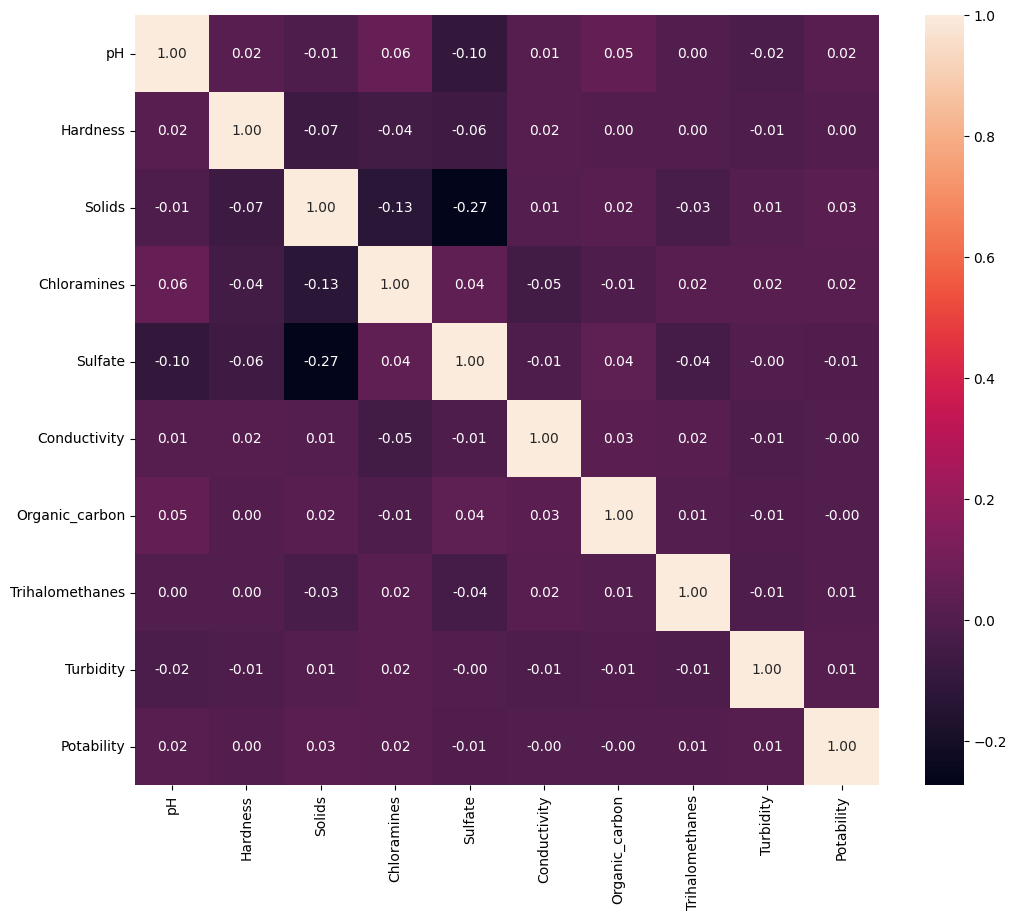

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f')

Nakon izvrsenog imputiranja praznih vrednosti, vidimo da se korelacija u krajnjem slucaju jos vise smanjila, sto je mozda i ocekivano.

Izvucicemo sve feature-e da bismo lakse izvukli šumove po svakoj koloni:

In [ ]:
numerical_features = df.columns.tolist()

### Metode detekcije outliera

| Metoda | Formula | Prag | Osetljivost | Tipican procenat outliera (normalna distribucija) |
|--------|---------|------|-------------|----------------------------------------------------|
| **Z-score** | (x - mean) / std | |z| > 3 | Niska (3 std od proseka) | ~0.27% |
| **IQR** | Q1 - 1.5*IQR, Q3 + 1.5*IQR | Van opsega | Visoka | ~4.3% |
| **Mod Z-score** | 0.6745(xi – x̃) / MAD | -3.5 > x > 3.5 | Srednja | ~0.05% |

- Vazno jer imamo relativno mali dataset (~3000 uzoraka) i ne mozemo sebi dozvoliti da izgubimo previse podataka
- RandomForest i ostali tree-based modeli su otporni na outliere, ali brisanje outliera i dalje moze da promeni ishod tacnosti modela

In [ ]:
def outliers_iqr(x: pd.Series):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((x > upper_bound) | (x < lower_bound))[0]

def outliers_z_score(ys: pd.Series):
    threshold = 3

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

def outliers_modified_z_score(ys: pd.Series):
    threshold = 3.5

    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    
    if median_absolute_deviation_y == 0:
        median_absolute_deviation_y = np.finfo(np.double).min
    
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)[0]


outliers = {}
print("Outliers:",' ' * 26,"IQR ZScore ModZScore")
for col in numerical_features:
    outliersIQR = outliers_iqr(df[col])
    outliersZScore = outliers_z_score(df[col])
    outliersModZScore = outliers_modified_z_score(df[col])
    outliers[col] = (outliersIQR, outliersZScore, outliersModZScore)
    print(f"Column '{col:24}': {len(outliersIQR):5} {len(outliersZScore):6} {len(outliersModZScore):9}")
print()



Outliers:                            IQR ZScore ModZScore
Column 'pH                      ':   122     27        25
Column 'Hardness                ':   124     27        22
Column 'Solids                  ':    59     31        14
Column 'Chloramines             ':    94     27        12
Column 'Sulfate                 ':   145     38        45
Column 'Conductivity            ':     9      7         1
Column 'Organic_carbon          ':    36      6         5
Column 'Trihalomethanes         ':    46     14        10
Column 'Turbidity               ':    19      9         0
Column 'Potability              ':     0      0         0



Od tri metode koje smo iskoristili, Z-score je "najmanje osetljiv" na sumove sto nam odgovara, jer ne smemo da brisemo previse redova zbog manjka podataka s kojim raspolazemo.

In [ ]:
z_scores = np.abs((df - df.mean()) / df.std())

# threshold for Z-scores
threshold = 3
outliers = (z_scores > threshold).any(axis=1)
# remove outliers
df_no_outliers = df[~outliers]


In [ ]:
# Evaluate models after outlier removal
clear_preprocessing_results()
results_df = evaluate_models_after_step(df_no_outliers, "2. Bez outliera", compare_scalers=False)


EVALUACIJA: 2. Bez outliera
Dataset: 4269 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1477), 1: np.int64(2792)}
  DecisionTree       | Accuracy: 0.8972 (+/- 0.0072)
  RandomForest       | Accuracy: 0.9026 (+/- 0.0040)
  ExtraTrees         | Accuracy: 0.9037 (+/- 0.0084)
  XGBoost            | Accuracy: 0.9049 (+/- 0.0056)
  LightGBM           | Accuracy: 0.8937 (+/- 0.0039)
  CatBoost           | Accuracy: 0.8681 (+/- 0.0077)
  KNN                | Accuracy: 0.7285 (+/- 0.0081)
  SVM                | Accuracy: 0.7302 (+/- 0.0080)

  NAJBOLJI: XGBoost (0.9049)
Step             2. Bez outliera
Model                    XGBoost
Accuracy_Mean           0.904896
Accuracy_Std            0.005601
F1                      0.931959
Recall                  0.995702
Precision               0.875908
Name: 3, dtype: object


In [ ]:
# Apply Modified Z-Score outlier detection and removal on df
def outliers_modified_z_score(ys: pd.Series):
    threshold = 3.5
    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    
    if median_absolute_deviation_y == 0:
        median_absolute_deviation_y = np.finfo(np.double).min
    
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)[0]

# Detect outliers in each feature
all_outlier_indices = set()
for col in df.columns[:-1]:  # Exclude Potability column
    outlier_indices = outliers_modified_z_score(df[col])
    all_outlier_indices.update(outlier_indices)

# Convert to sorted list for dropping
outlier_indices_to_drop = sorted(list(all_outlier_indices))

print(f"Ukupno detektovanih outliera: {len(outlier_indices_to_drop)}")
print(f"Originalni broj redova: {len(df)}")

# Remove outliers
df = df.drop(df.index[outlier_indices_to_drop])

print(f"Novi broj redova nakon uklanjanja outliera: {len(df)}")
print(f"Uklonjeno redova: {len(outlier_indices_to_drop)} ({100*len(outlier_indices_to_drop)/len(df):.2f}%)")

# Evaluate models after outlier removal with Modified Z-Score
clear_preprocessing_results()
evaluate_models_after_step(df, "3. Bez outliera (Modified Z-Score)", compare_scalers=False)

Ukupno detektovanih outliera: 34
Originalni broj redova: 2495
Novi broj redova nakon uklanjanja outliera: 2461
Uklonjeno redova: 34 (1.38%)

EVALUACIJA: 3. Bez outliera (Modified Z-Score)
Dataset: 2461 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1508), 1: np.int64(953)}
  DecisionTree       | Accuracy: 0.5815 (+/- 0.0212)
  RandomForest       | Accuracy: 0.6713 (+/- 0.0130)


Ukupno detektovanih outliera: 34
Originalni broj redova: 2495
Novi broj redova nakon uklanjanja outliera: 2461
Uklonjeno redova: 34 (1.38%)

EVALUACIJA: 3. Bez outliera (Modified Z-Score)
Dataset: 2461 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1508), 1: np.int64(953)}
  DecisionTree       | Accuracy: 0.5815 (+/- 0.0212)
  RandomForest       | Accuracy: 0.6713 (+/- 0.0130)


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jelen\OneDrive\Documents\_Master\Masinsko ucenje\Git\New folder\SetupJupyter\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jelen\OneDrive\Documents\_Master\Masinsko ucenje\Git\New folder\SetupJupyter\.venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\jelen\OneDrive\Documents\_Master\Masinsko ucenje\Git\New folder\SetupJupyter\.venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 377, in fit
    estimator._compute_missing_values_in_feature_mask(
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        X, estimator_name=self.__class__.__name__
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\jelen\OneDrive\Documents\_Master\Masinsko ucenje\Git\New folder\SetupJupyter\.venv\Lib\site-packages\sklearn\tree\_classes.py", line 214, in _compute_missing_values_in_feature_mask
    assert_all_finite(X, **common_kwargs)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jelen\OneDrive\Documents\_Master\Masinsko ucenje\Git\New folder\SetupJupyter\.venv\Lib\site-packages\sklearn\utils\validation.py", line 213, in assert_all_finite
    _assert_all_finite(
    ~~~~~~~~~~~~~~~~~~^
        X.data if sp.issparse(X) else X,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<2 lines>...
        input_name=input_name,
        ^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\jelen\OneDrive\Documents\_Master\Masinsko ucenje\Git\New folder\SetupJupyter\.venv\Lib\site-packages\sklearn\utils\validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        X,
        ^^
    ...<4 lines>...
        input_name=input_name,
        ^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\jelen\OneDrive\Documents\_Master\Masinsko ucenje\Git\New folder\SetupJupyter\.venv\Lib\site-packages\sklearn\utils\validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
ExtraTreesClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
# threshold for Z-scores
outliersModZScore = outliers_modified_z_score(df["Sulfate"])

# Normalizuj uvek na indekse dataframe-a (radi i kada outliersModZScore vrati tuple iz np.where)
outlier_idx = outliersModZScore[0] if isinstance(outliersModZScore, tuple) else outliersModZScore
outlier_idx = df.index[outlier_idx]
print(f"Outliers detected by Modified Z-Score in 'Sulfate': {len(outlier_idx)}")

# remove outliers
df_no_outliers_2 = df.drop(index=outlier_idx)

# Evaluate models after outlier removal
clear_preprocessing_results()
results_df = evaluate_models_after_step(df_no_outliers_2, "2. Bez outliera ModZScore", compare_scalers=False)


Outliers detected by Modified Z-Score in 'Sulfate': 14

EVALUACIJA: 2. Bez outliera ModZScore
Dataset: 2369 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1465), 1: np.int64(904)}
  DecisionTree       | Accuracy: 0.7096 (+/- 0.0149)
  RandomForest       | Accuracy: 0.7775 (+/- 0.0193)
  ExtraTrees         | Accuracy: 0.6859 (+/- 0.0146)
  XGBoost            | Accuracy: 0.7788 (+/- 0.0141)
  LightGBM           | Accuracy: 0.7763 (+/- 0.0223)
  CatBoost           | Accuracy: 0.7868 (+/- 0.0160)
  KNN                | Accuracy: 0.6256 (+/- 0.0209)
  SVM                | Accuracy: 0.6720 (+/- 0.0067)

  NAJBOLJI: CatBoost (0.7868)
Step             2. Bez outliera ModZScore
Model                             CatBoost
Accuracy_Mean                      0.78683
Accuracy_Std                      0.015957
F1                                0.676746
Recall                            0.586323
Precision                         0.802015
Name: 5, dtype: object


In [ ]:
df = df_no_outliers.copy()

### Zakljucak nakon brisanja outliera
Kao sto vidimo, tacnost modela nam se pogorsala nakon sto smo obrisali outliere, sto je i ocekivano, jer najmanja promena u broju podataka moze da napravi jak efekat na tacnost modela zbog malog broja podataka. Stoga, zadrzacemo sve outliere kako bismo odrzali sto vecu tacnost.

## Balansiranje klasa (Resampling)

Nebalansirane klase su cest problem u klasifikaciji. U nasem datasetu imamo vise nepitke vode (~60%) nego pitke (~40%). Ovo moze navesti model da "favorizuje" vecinu klasu.

**Vazno:** Balansiranje se mora raditi **samo na train setu** da bi se izbeglo curenje podataka (data leakage). Ako radimo upsampling na celom datasetu pre split-a, isti (duplirani) podaci mogu zavrsiti i u train i u test setu, sto daje lazno optimisticne rezultate.

Poredimo dve tehnike:
- **Upsampling**: Dupliramo uzorke manjinske klase da bismo dobili vise podataka za trening
- **Downsampling**: Smanjujemo uzorke vecinske klase da bismo imali balansirane klase

In [ ]:
# Balansiranje klasa - poređenje svih metoda sa SVIM METRIKAMA
%pip install imblearn

from sklearn.utils import resample, shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

def balance_train_data(X_train, y_train, method='upsample', random_state=42):
    """
    Balansira train podatke koristeci upsampling, downsampling ili SMOTE.
    """
    if method == 'none':
        return X_train, y_train

    if method == 'smote':
        smote = SMOTE(random_state=random_state)
        X_balanced, y_balanced = smote.fit_resample(X_train, y_train)
        return X_balanced, y_balanced

    train_data = pd.DataFrame(X_train.copy())
    train_data['target'] = y_train

    class_0 = train_data[train_data['target'] == 0]
    class_1 = train_data[train_data['target'] == 1]

    if method == 'upsample':
        n_samples = max(len(class_0), len(class_1))
        if len(class_0) < len(class_1):
            class_0 = resample(class_0, replace=True, n_samples=n_samples, random_state=random_state)
        else:
            class_1 = resample(class_1, replace=True, n_samples=n_samples, random_state=random_state)
    else:  # downsample
        n_samples = min(len(class_0), len(class_1))
        if len(class_0) > len(class_1):
            class_0 = resample(class_0, replace=False, n_samples=n_samples, random_state=random_state)
        else:
            class_1 = resample(class_1, replace=False, n_samples=n_samples, random_state=random_state)

    balanced_data = pd.concat([class_0, class_1])
    balanced_data = shuffle(balanced_data, random_state=random_state)

    X_balanced = balanced_data.drop('target', axis=1).values
    y_balanced = balanced_data['target'].values

    return X_balanced, y_balanced

def evaluate_all_metrics(df_data, method='none', target_col='Potability', k=5):

    X = df_data.drop(columns=[target_col]).values
    y = df_data[target_col].values

    models = {
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(random_state=42, verbosity=0, n_jobs=-1),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
        'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    }

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'recall': [], 'auc': []}
               for name in models.keys()}

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        X_train_balanced, y_train_balanced = balance_train_data(X_train, y_train, method=method, random_state=42+fold)

        for name, model in models.items():
            from sklearn.base import clone
            model_clone = clone(model)
            model_clone.fit(X_train_balanced, y_train_balanced)

            y_pred = model_clone.predict(X_test)
            y_proba = model_clone.predict_proba(X_test)[:, 1]

            results[name]['accuracy'].append(accuracy_score(y_test, y_pred))
            results[name]['f1'].append(f1_score(y_test, y_pred))
            results[name]['precision'].append(precision_score(y_test, y_pred))
            results[name]['recall'].append(recall_score(y_test, y_pred))
            results[name]['auc'].append(roc_auc_score(y_test, y_proba))

    summary = []
    for name, metrics in results.items():
        summary.append({
            'Model': name,
            'Accuracy': np.mean(metrics['accuracy']),
            'F1': np.mean(metrics['f1']),
            'Precision': np.mean(metrics['precision']),
            'Recall': np.mean(metrics['recall']),
            'AUC': np.mean(metrics['auc'])
        })

    return pd.DataFrame(summary)

# Distribucija klasa
print("Distribucija klasa:")
print(df['Potability'].value_counts())
print(f"Odnos: {df['Potability'].value_counts()[0]/len(df)*100:.1f}% / {df['Potability'].value_counts()[1]/len(df)*100:.1f}%")

# Evaluacija svih metoda
methods = {
    'BEZ BALANSIRANJA': 'none',
    'UPSAMPLING': 'upsample',
    'DOWNSAMPLING': 'downsample',
    'SMOTE': 'smote'
}

all_results = {}
for name, method in methods.items():
    print(f"\nEvaluacija: {name}...")
    all_results[name] = evaluate_all_metrics(df, method=method, k=5)

# Prikaz rezultata za svaku metodu
for name, results_df in all_results.items():
    print()
    print("=" * 85)
    print(f"{name}")
    print("=" * 85)
    print(results_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# UPOREDNA TABELA - prosek svih modela po metodi
print()
print("=" * 85)
print("PROSECNE METRIKE PO METODI BALANSIRANJA (prosek svih modela)")
print("=" * 85)

comparison_data = []
for name, results_df in all_results.items():
    comparison_data.append({
        'Metoda': name,
        'Accuracy': results_df['Accuracy'].mean(),
        'F1': results_df['F1'].mean(),
        'Precision': results_df['Precision'].mean(),
        'Recall': results_df['Recall'].mean(),
        'AUC': results_df['AUC'].mean()
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# Najbolja metoda po svakoj metrici
print()
print("=" * 85)
print("NAJBOLJA METODA PO SVAKOJ METRICI")
print("=" * 85)
for metric in ['Accuracy', 'F1', 'Precision', 'Recall', 'AUC']:
    best_idx = comparison_df[metric].idxmax()
    best_method = comparison_df.loc[best_idx, 'Metoda']
    best_value = comparison_df.loc[best_idx, metric]
    print(f"  {metric:12} -> {best_method:20} ({best_value:.4f})")

Note: you may need to restart the kernel to use updated packages.
Distribucija klasa:
Potability
1    1671
0    1598
Name: count, dtype: int64
Odnos: 48.9% / 51.1%

Evaluacija: BEZ BALANSIRANJA...

Evaluacija: UPSAMPLING...

Evaluacija: DOWNSAMPLING...

Evaluacija: SMOTE...


ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
#SMOTE je najbolja metoda balansiranja na ovom skupu podataka!
smote = SMOTE(random_state=42)
X = df.drop(columns=['Potability'])
y = df['Potability']

X_smote, y_smote = smote.fit_resample(X, y)
balanced_data = pd.concat(
    [pd.DataFrame(X_smote, columns=X.columns), pd.Series(y_smote, name='Potability')],
    axis=1
)

print("Posle SMOTE balansiranja:")
print(balanced_data['Potability'].value_counts())

Posle SMOTE balansiranja:
Potability
0    2926
1    2926
Name: count, dtype: int64


In [ ]:
# Balansiranje DOWNSAMPLING         
#class_0 = df[df['Potability'] == 0]
#class_1 = df[df['Potability'] == 1]

# downsample
#n_samples = min(len(class_0), len(class_1))
#if len(class_0) > len(class_1):
#    class_0 = resample(class_0, replace=False, n_samples=n_samples, random_state=42)
#else:
#    class_1 = resample(class_1, replace=False, n_samples=n_samples, random_state=42)

#balanced_data = pd.concat([class_0, class_1])
#balanced_data = shuffle(balanced_data, random_state=42)

In [ ]:
clear_preprocessing_results()
results_df = evaluate_models_after_step(balanced_data, "4. Balance", compare_scalers=False)


EVALUACIJA: 4. Balance
Dataset: 5852 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(2926), 1: np.int64(2926)}
  DecisionTree       | Accuracy: 0.9067 (+/- 0.0107)
  RandomForest       | Accuracy: 0.9600 (+/- 0.0084)
  ExtraTrees         | Accuracy: 0.9404 (+/- 0.0051)
  XGBoost            | Accuracy: 0.9564 (+/- 0.0022)
  LightGBM           | Accuracy: 0.9301 (+/- 0.0086)
  CatBoost           | Accuracy: 0.9130 (+/- 0.0126)
  KNN                | Accuracy: 0.7702 (+/- 0.0083)
  SVM                | Accuracy: 0.7486 (+/- 0.0112)

  NAJBOLJI: RandomForest (0.9600)
Step               4. Balance
Model            RandomForest
Accuracy_Mean        0.960015
Accuracy_Std         0.008424
F1                   0.960701
Recall                0.97642
Precision            0.945551
Name: 1, dtype: object


In [ ]:
df = balanced_data.copy()

In [ ]:
import time

results, summary_df = hyperparameter_optimization(
    df, 
    target_col='Potability',
    models_to_tune=['CatBoost', 'RandomForest'],
    scaler='standard',
    cv=5,
    scoring='accuracy', 
    use_randomized=True,  
    n_iter=50
)


Skaler: standard, CV: 5, Scoring: accuracy
Metod: RandomizedSearchCV

Optimizacija: RandomForest...
  Najbolji score: 0.9544
  Najbolji parametri: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}

Optimizacija: CatBoost...
  Najbolji score: 0.9663
  Najbolji parametri: {'random_strength': 1, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 800, 'depth': 10, 'bagging_temperature': 0}

SUMARNI PREGLED - RANGIRANO PO SCORE-u:
  CatBoost        | Score: 0.9663
  RandomForest    | Score: 0.9544


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Definicija metrika za cross_validate
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision_0': make_scorer(precision_score, pos_label=0),
    'precision_1': make_scorer(precision_score, pos_label=1),
    'recall_0': make_scorer(recall_score, pos_label=0),
    'recall_1': make_scorer(recall_score, pos_label=1),
    'f1_0': make_scorer(f1_score, pos_label=0),
    'f1_1': make_scorer(f1_score, pos_label=1)
}

def test_model(model, X: pd.DataFrame, Y: pd.DataFrame):
    #Prepare testing objects
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    #Training and testing
    cv_results = cross_validate(model, X, Y, scoring=scoring_metrics,
     cv=cv, n_jobs=-1)

    AccuScores = cv_results['test_accuracy']
    Prec0Scores = cv_results['test_precision_0']
    Prec1Scores = cv_results['test_precision_1']
    Rec0Scores = cv_results['test_recall_0']
    Rec1Scores = cv_results['test_recall_1']
    F10Scores = cv_results['test_f1_0']
    F11Scores = cv_results['test_f1_1']

    return { 
        'Accuracy': np.mean(AccuScores),
        'Precision 0': np.mean(Prec0Scores),
        'Precision 1': np.mean(Prec1Scores),
        'Recall 0': np.mean(Rec0Scores),
        'Recall 1': np.mean(Rec1Scores),
        'F1 0': np.mean(F10Scores),
        'F1 1': np.mean(F11Scores)
    }

## Evaluacija najboljeg modela
Matrica konfuzije, Feature Importance, ROC kriva i AUC score.

In [ ]:
# Primena izabranih tranformacija nad test podacima
# imputacija
rows_with_multiple_nulls = df_test[df_test.isnull().sum(axis=1) >= 2]
df_test = df_test.drop(rows_with_multiple_nulls.index)

# Grupna mean imputacija (po Potability)
for col in ['pH', 'Sulfate', 'Trihalomethanes']:
    df_test[col] = df_test[col].fillna(df_test.groupby('Potability')[col].transform('mean'))



0:	learn: 0.6550599	total: 24.2ms	remaining: 19.4s
1:	learn: 0.6260209	total: 38.8ms	remaining: 15.5s
2:	learn: 0.5916458	total: 51.1ms	remaining: 13.6s
3:	learn: 0.5636632	total: 63.4ms	remaining: 12.6s
4:	learn: 0.5388759	total: 75.9ms	remaining: 12.1s
5:	learn: 0.5129894	total: 88.9ms	remaining: 11.8s
6:	learn: 0.4869721	total: 101ms	remaining: 11.5s
7:	learn: 0.4702429	total: 114ms	remaining: 11.3s
8:	learn: 0.4574882	total: 126ms	remaining: 11.1s
9:	learn: 0.4375017	total: 140ms	remaining: 11s
10:	learn: 0.4244430	total: 152ms	remaining: 10.9s
11:	learn: 0.4048349	total: 165ms	remaining: 10.8s
12:	learn: 0.3898998	total: 179ms	remaining: 10.8s
13:	learn: 0.3787435	total: 191ms	remaining: 10.7s
14:	learn: 0.3657871	total: 203ms	remaining: 10.6s
15:	learn: 0.3536362	total: 215ms	remaining: 10.5s
16:	learn: 0.3419306	total: 227ms	remaining: 10.5s
17:	learn: 0.3279841	total: 240ms	remaining: 10.4s
18:	learn: 0.3201450	total: 254ms	remaining: 10.4s
19:	learn: 0.3127801	total: 266ms	rem

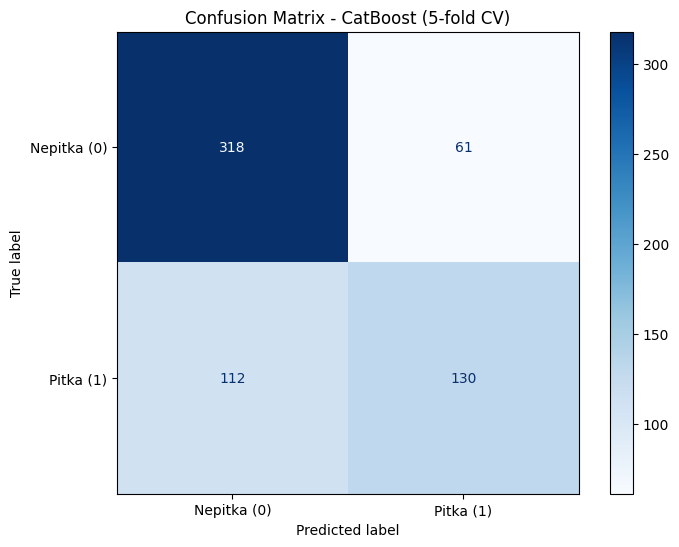

True Negatives (TN): 318
False Positives (FP): 61
False Negatives (FN): 112
True Positives (TP): 130

Accuracy: 0.7214
Precision (Pitka): 0.6806
Recall (Pitka): 0.5372
F1 Score (Pitka): 0.6005


In [ ]:
# =============================================================================
# EVALUACIJA NAJBOLJEG MODELA - Cross-Validation sa matricom konfuzije
# =============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score

# Priprema podataka
X = df_test.drop('Potability', axis=1)
y = df_test['Potability']

# CatBoost model
model = CatBoostClassifier(random_strength=1, learning_rate=0.05, l2_leaf_reg=1, iterations=800, depth=10, bagging_temperature=0)

#model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)

# Cross-validation predikcije (svaki uzorak se predvidja kad je u test foldu)
y_pred_cv = cross_val_predict(model, X, y, cv=5)
y_pred_proba_cv = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Cross-validation scores
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("CROSS-VALIDATION REZULTATI (5-fold):")
print("="*60)
print(f"Accuracy po foldovima: {cv_scores}")
print(f"Prosecna accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Classification report
print("\nCLASSIFICATION REPORT (cross-validated):")
print("="*60)
print(classification_report(y, y_pred_cv, target_names=['Nepitka (0)', 'Pitka (1)']))

# Confusion Matrix (agregirana iz svih foldova)
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nepitka (0)', 'Pitka (1)'])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix - CatBoost (5-fold CV)')
plt.show()

# Prikaz vrednosti
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nAccuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision (Pitka): {tp / (tp + fp):.4f}")
print(f"Recall (Pitka): {tp / (tp + fn):.4f}")
print(f"F1 Score (Pitka): {2*tp / (2*tp + fp + fn):.4f}")

0:	learn: 0.6810368	total: 3.89ms	remaining: 1.94s
1:	learn: 0.6696532	total: 7.76ms	remaining: 1.93s
2:	learn: 0.6606171	total: 11.6ms	remaining: 1.92s
3:	learn: 0.6481498	total: 14.2ms	remaining: 1.76s
4:	learn: 0.6345554	total: 18.1ms	remaining: 1.79s
5:	learn: 0.6230578	total: 21.6ms	remaining: 1.78s
6:	learn: 0.6139265	total: 25.1ms	remaining: 1.77s
7:	learn: 0.6001792	total: 29.6ms	remaining: 1.82s
8:	learn: 0.5945399	total: 33.1ms	remaining: 1.81s
9:	learn: 0.5845746	total: 36.6ms	remaining: 1.79s
10:	learn: 0.5762507	total: 41ms	remaining: 1.82s
11:	learn: 0.5684114	total: 44.7ms	remaining: 1.82s
12:	learn: 0.5590303	total: 48.6ms	remaining: 1.82s
13:	learn: 0.5513362	total: 52.2ms	remaining: 1.81s
14:	learn: 0.5433495	total: 55.9ms	remaining: 1.81s
15:	learn: 0.5335824	total: 60ms	remaining: 1.81s
16:	learn: 0.5271696	total: 64.1ms	remaining: 1.82s
17:	learn: 0.5208452	total: 67.6ms	remaining: 1.81s
18:	learn: 0.5154713	total: 71.2ms	remaining: 1.8s
19:	learn: 0.5119388	total:

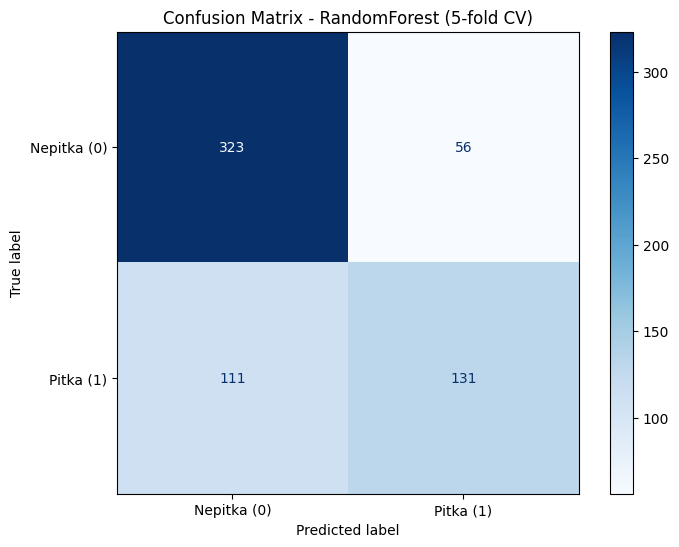

True Negatives (TN): 323
False Positives (FP): 56
False Negatives (FN): 111
True Positives (TP): 131

Accuracy: 0.7311
Precision (Pitka): 0.7005
Recall (Pitka): 0.5413
F1 Score (Pitka): 0.6107


In [ ]:
# =============================================================================
# EVALUACIJA NAJBOLJEG MODELA - Cross-Validation sa matricom konfuzije
# =============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score

# Priprema podataka
X = df_test.drop('Potability', axis=1)
y = df_test['Potability']

# RandomForest model
model = CatBoostClassifier(random_strength=2, learning_rate=0.05, l2_leaf_reg=5, iterations=500, depth=8, bagging_temperature=0)

# Cross-validation predikcije (svaki uzorak se predvidja kad je u test foldu)
y_pred_cv = cross_val_predict(model, X, y, cv=5)
y_pred_proba_cv = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Cross-validation scores
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("CROSS-VALIDATION REZULTATI (5-fold):")
print("="*60)
print(f"Accuracy po foldovima: {cv_scores}")
print(f"Prosecna accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Classification report
print("\nCLASSIFICATION REPORT (cross-validated):")
print("="*60)
print(classification_report(y, y_pred_cv, target_names=['Nepitka (0)', 'Pitka (1)']))

# Confusion Matrix (agregirana iz svih foldova)
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nepitka (0)', 'Pitka (1)'])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix - RandomForest (5-fold CV)')
plt.show()

# Prikaz vrednosti
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nAccuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision (Pitka): {tp / (tp + fp):.4f}")
print(f"Recall (Pitka): {tp / (tp + fn):.4f}")
print(f"F1 Score (Pitka): {2*tp / (2*tp + fp + fn):.4f}")

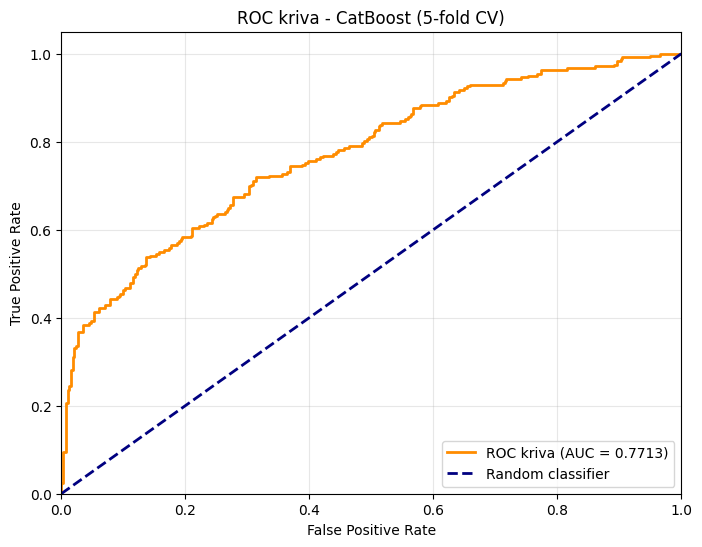

AUC Score: 0.7713


In [ ]:
# ROC kriva i AUC (cross-validated)
fpr, tpr, thresholds = roc_curve(y, y_pred_proba_cv)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC kriva (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC kriva - CatBoost (5-fold CV)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

### Sumarna tabela: Baseline vs Finalni model

0:	learn: 0.6776427	total: 4.4ms	remaining: 2.2s
1:	learn: 0.6615905	total: 8.21ms	remaining: 2.04s
2:	learn: 0.6496661	total: 12.4ms	remaining: 2.05s
3:	learn: 0.6353297	total: 16.1ms	remaining: 2s
4:	learn: 0.6233453	total: 19.7ms	remaining: 1.95s
5:	learn: 0.6123920	total: 23.6ms	remaining: 1.94s
6:	learn: 0.6035868	total: 26.9ms	remaining: 1.9s
7:	learn: 0.5938191	total: 30.6ms	remaining: 1.88s
8:	learn: 0.5829120	total: 34.8ms	remaining: 1.9s
9:	learn: 0.5693175	total: 38.4ms	remaining: 1.88s
10:	learn: 0.5594832	total: 42ms	remaining: 1.87s
11:	learn: 0.5496978	total: 45.9ms	remaining: 1.87s
12:	learn: 0.5403678	total: 49.3ms	remaining: 1.85s
13:	learn: 0.5299750	total: 52.9ms	remaining: 1.84s
14:	learn: 0.5260038	total: 56.3ms	remaining: 1.82s
15:	learn: 0.5199141	total: 59.8ms	remaining: 1.81s
16:	learn: 0.5145537	total: 63.3ms	remaining: 1.8s
17:	learn: 0.5099336	total: 66.7ms	remaining: 1.78s
18:	learn: 0.5045584	total: 69.8ms	remaining: 1.77s
19:	learn: 0.5001904	total: 73.3

0:	learn: 0.6776427	total: 4.4ms	remaining: 2.2s
1:	learn: 0.6615905	total: 8.21ms	remaining: 2.04s
2:	learn: 0.6496661	total: 12.4ms	remaining: 2.05s
3:	learn: 0.6353297	total: 16.1ms	remaining: 2s
4:	learn: 0.6233453	total: 19.7ms	remaining: 1.95s
5:	learn: 0.6123920	total: 23.6ms	remaining: 1.94s
6:	learn: 0.6035868	total: 26.9ms	remaining: 1.9s
7:	learn: 0.5938191	total: 30.6ms	remaining: 1.88s
8:	learn: 0.5829120	total: 34.8ms	remaining: 1.9s
9:	learn: 0.5693175	total: 38.4ms	remaining: 1.88s
10:	learn: 0.5594832	total: 42ms	remaining: 1.87s
11:	learn: 0.5496978	total: 45.9ms	remaining: 1.87s
12:	learn: 0.5403678	total: 49.3ms	remaining: 1.85s
13:	learn: 0.5299750	total: 52.9ms	remaining: 1.84s
14:	learn: 0.5260038	total: 56.3ms	remaining: 1.82s
15:	learn: 0.5199141	total: 59.8ms	remaining: 1.81s
16:	learn: 0.5145537	total: 63.3ms	remaining: 1.8s
17:	learn: 0.5099336	total: 66.7ms	remaining: 1.78s
18:	learn: 0.5045584	total: 69.8ms	remaining: 1.77s
19:	learn: 0.5001904	total: 73.3

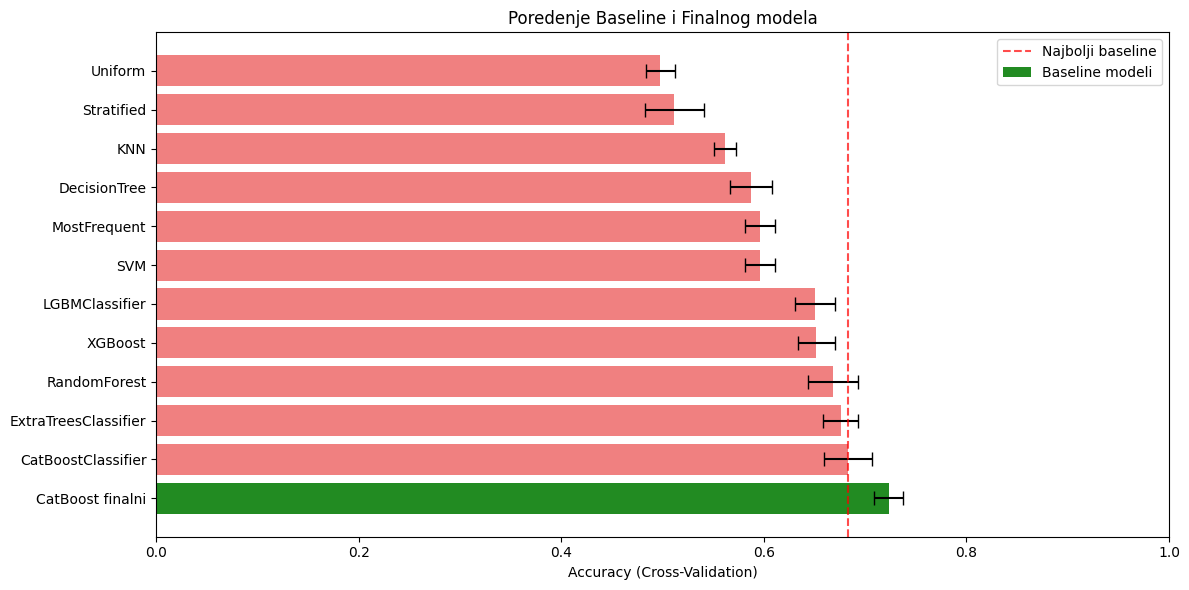


Poboljsanje u odnosu na najbolji baseline: 5.82%
Baseline (best): 0.6833 -> Finalni: 0.7231


In [ ]:
# Sumarna tabela: Baseline vs Finalni rezultati
from sklearn.metrics import precision_score, recall_score, f1_score

# Finalni model accuracy (sa CV)
kf_final = KFold(n_splits=5, shuffle=True, random_state=42)
final_model_for_cv = CatBoostClassifier(random_strength=2, learning_rate=0.05, l2_leaf_reg=5, iterations=500, depth=8, bagging_temperature=0)


final_cv_scores = cross_val_score(final_model_for_cv, X, y, cv=kf_final)

# Kreiranje sumarne tabele
summary_data = {
    'Model': [],
    'Accuracy (CV)': [],
    'Std': [],
    'Tip': []
}

# Baseline rezultati
for name, result in baseline_results_cv.items():
    summary_data['Model'].append(name)
    summary_data['Accuracy (CV)'].append(result['mean'])
    summary_data['Std'].append(result['std'])
    summary_data['Tip'].append('Baseline')

# Finalni model
summary_data['Model'].append('CatBoost finalni')
summary_data['Accuracy (CV)'].append(final_cv_scores.mean())
summary_data['Std'].append(final_cv_scores.std())
summary_data['Tip'].append('Finalni')

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Accuracy (CV)', ascending=False)

print("=" * 70)
print("SUMARNA TABELA: BASELINE vs FINALNI MODEL")
print("=" * 70)
print(summary_df.to_string(index=False))
print("=" * 70)

# Vizualizacija
plt.figure(figsize=(12, 6))
colors = ['lightcoral' if t == 'Baseline' else 'forestgreen' for t in summary_df['Tip']]
bars = plt.barh(summary_df['Model'], summary_df['Accuracy (CV)'], color=colors, xerr=summary_df['Std'], capsize=5)
plt.xlabel('Accuracy (Cross-Validation)')
plt.title('Poredenje Baseline i Finalnog modela')
plt.xlim(0, 1)
plt.axvline(x=summary_df[summary_df['Tip']=='Baseline']['Accuracy (CV)'].max(), 
            color='red', linestyle='--', alpha=0.7, label='Najbolji baseline')
plt.legend(['Najbolji baseline', 'Baseline modeli', 'Finalni model'])
plt.tight_layout()
plt.show()

# Poboljsanje
baseline_best = summary_df[summary_df['Tip']=='Baseline']['Accuracy (CV)'].max()
final_acc = summary_df[summary_df['Tip']=='Finalni']['Accuracy (CV)'].values[0]
improvement = ((final_acc - baseline_best) / baseline_best) * 100
print(f"\nPoboljsanje u odnosu na najbolji baseline: {improvement:.2f}%")
print(f"Baseline (best): {baseline_best:.4f} -> Finalni: {final_acc:.4f}")

### Feature Importance (Vaznost osobina)

Feature Importance pokazuje koliko svaka osobina doprinosi predikcijama modela. 
Moze da sadrzi:

- **Visoku vaznost**: Osobina ima veliki uticaj na predikcije
- **Nisku vaznost**: Osobina malo doprinosi - moze se eventualno ukloniti
- **Relativnu vrednost**: Vaznost je normalizovana (suma = 1)

Ocekujemo da hemijski parametri poput pH, Sulfata i tvrdoce vode budu medju najvaznijim jer:
- pH direktno utice na pitkost (7 je neutralno)
- Sulfati u visokim koncentracijama mogu biti stetni
- Tvrdoca vode utice na ukus i upotrebljivost

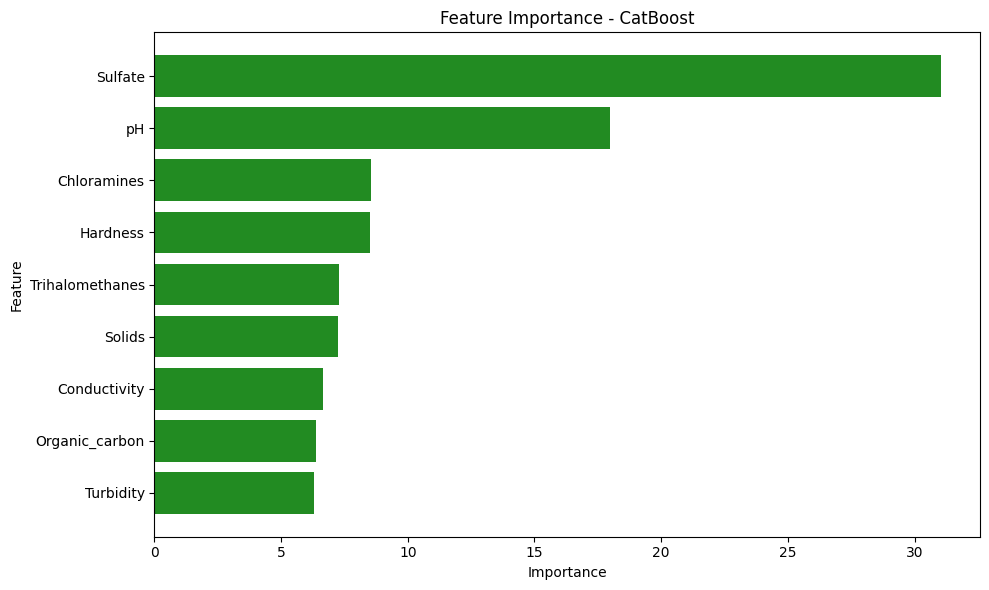


Feature Importance ranking (CatBoost):
  Sulfate: 31.0297
  pH: 17.9924
  Chloramines: 8.5506
  Hardness: 8.4980
  Trihalomethanes: 7.2927
  Solids: 7.2632
  Conductivity: 6.6707
  Organic_carbon: 6.3964
  Turbidity: 6.3064


In [ ]:
# Feature Importance - CatBoost
# Treniraj model na celom datasetu za feature importance
X = df.drop('Potability', axis=1)
y = df['Potability']
features = X.columns.tolist()

model_fi = CatBoostClassifier(random_strength=2, learning_rate=0.05, l2_leaf_reg=5, iterations=500, depth=8, bagging_temperature=0, verbose=0)

model_fi.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model_fi.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='forestgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoost')
plt.tight_layout()
plt.show()

print("\nFeature Importance ranking (CatBoost):")
for idx, row in feature_importance.sort_values('importance', ascending=False).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

## Analiza interpretabilnosti modela (LIME i SHAP)

SHAP racuna doprinos svake osobine predikciji koristeci Shapley vrednosti iz teorije igara:
1. Za svaku osobinu, racuna se koliko bi se predikcija promenila ako tu osobinu "izbacimo"
2. Ovo se radi za sve moguce kombinacije osobina
3. Rezultat je ponderisani prosek doprinosa

LIME (Local Interpretable Model-agnostic Explanations):
1. Uzima instancu koju zelimo objasniti
2. Pravi perturbacije (varijacije) oko te instance
3. Trenira jednostavan linearni model na tim perturbacijama
4. Koeficijenti linearnog modela = objasnjenje


In [ ]:
import shap
import lime
import lime.lime_tabular
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ============================================================================
# SHAP I LIME NA OBRAĐENIM PODACIMA
# ============================================================================
# NAPOMENA: df je već TRAIN SET (splitovanje urađeno u cell 7)
# df_test već postoji i koristi se za finalno testiranje

# Priprema podataka - koristimo df (koji je već df_train!)
X_train = df.drop('Potability', axis=1)
y_train = df['Potability']

# Test podaci - koristi se već postojeći df_test
X_test = df_test.drop('Potability', axis=1)
y_test = df_test['Potability']

features = X_train.columns.tolist()

print("=" * 70)
print("PRIPREMA PODATAKA ZA SHAP/LIME ANALIZU")
print("=" * 70)
print("✓ Koristi se već postojeći train/test split iz cell 7")
print(f"Train set: {len(X_train)} uzoraka (df = df_train)")
print(f"Test set:  {len(X_test)} uzoraka (df_test)")

# OBRADA PODATAKA - imputacija fitovana NA TRAIN setu
print("\n1. Imputacija podataka...")
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)  # FIT na train
X_test_imputed = imputer.transform(X_test)        # TRANSFORM test

# Konvertuj nazad u DataFrame da bi zadržali imena kolona
X_train_processed = pd.DataFrame(X_train_imputed, columns=features)
X_test_processed = pd.DataFrame(X_test_imputed, columns=features)

print("   ✓ Null vrednosti imputirane (strategija: mean)")
print(f"   ✓ Train set: {X_train_processed.isnull().sum().sum()} null vrednosti")
print(f"   ✓ Test set:  {X_test_processed.isnull().sum().sum()} null vrednosti")

# TRENIRANJE MODELA NA OBRAĐENIM PODACIMA
print("\n2. Treniranje CatBoost modela...")
model = CatBoostClassifier(
    random_strength=2, 
    learning_rate=0.05, 
    l2_leaf_reg=5, 
    iterations=500, 
    depth=8, 
    bagging_temperature=0, 
    verbose=0
)

model.fit(X_train_processed, y_train)
print("   ✓ Model obučen na obrađenim train podacima")

# EVALUACIJA
y_pred = model.predict(X_test_processed)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
test_accuracy = (y_pred == y_test).mean()

print(f"\n3. Evaluacija na test setu:")
print(f"   Test Accuracy: {test_accuracy:.4f}")

# SHAP ANALIZA NA OBRAĐENIM TEST PODACIMA
print("\n4. Kreiranje SHAP explainer-a...")
explainer_shap = shap.TreeExplainer(model)

print("   Računanje SHAP vrednosti na OBRAĐENIM test podacima...")
shap_values = explainer_shap.shap_values(X_test_processed)
print("   ✓ SHAP vrednosti izračunate!")

# LIME EXPLAINER SA OBRAĐENIM TRAIN PODACIMA
print("\n5. Kreiranje LIME explainer-a...")
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_processed.values,  # Background iz obrađenog train seta
    feature_names=features,
    class_names=['Nepitka', 'Pitka'],
    mode='classification'
)
print("   ✓ LIME explainer inicijalizovan sa obrađenim train podacima")

print("\n" + "=" * 70)
print("PRIPREMA ZAVRŠENA - Podaci spremni za SHAP/LIME vizualizacije")
print("=" * 70)

# Ažuriraj X_test za dalje korišćenje u vizualizacijama
X_test = X_test_processed

c:\Users\jelen\OneDrive\Documents\_Master\Masinsko ucenje\Git\New folder\SetupJupyter\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\jelen\OneDrive\Documents\_Master\Masinsko ucenje\Git\New folder\SetupJupyter\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PRIPREMA PODATAKA ZA SHAP/LIME ANALIZU
✓ Koristi se već postojeći train/test split iz cell 7
Train set: 1840 uzoraka (df = df_train)
Test set:  621 uzoraka (df_test)

1. Imputacija podataka...
   ✓ Null vrednosti imputirane (strategija: mean)
   ✓ Train set: 0 null vrednosti
   ✓ Test set:  0 null vrednosti

2. Treniranje CatBoost modela...
   ✓ Model obučen na obrađenim train podacima

3. Evaluacija na test setu:
   Test Accuracy: 0.6055

4. Kreiranje SHAP explainer-a...
   Računanje SHAP vrednosti na OBRAĐENIM test podacima...
   ✓ SHAP vrednosti izračunate!

5. Kreiranje LIME explainer-a...
   ✓ LIME explainer inicijalizovan sa obrađenim train podacima

PRIPREMA ZAVRŠENA - Podaci spremni za SHAP/LIME vizualizacije


### ✅ Objašnjenje ispravki za SHAP/LIME

**Šta je promenjeno u odnosu na prethodnu verziju:**

**RANIJE (POGREŠNO):**
```python
X_train, X_test = train_test_split(X, y)  # Sirovi podaci
model.fit(X_train, y_train)  # Model treniran NA SIROVIM podacima sa NaN
shap_values = explainer.shap_values(X_test)  # SHAP NA SIROVIM podacima
```

**SADA (ISPRAVNO):**
```python
X_train, X_test = train_test_split(X, y)
imputer.fit(X_train)  # Fitovano NA TRAIN
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)  # Transformacija test seta

model.fit(X_train_imputed, y_train)  # Model NA OBRAĐENIM podacima
shap_values = explainer.shap_values(X_test_imputed)  # SHAP NA OBRAĐENIM
```

**Zašto je bitno:**
1. ✅ Model vidi iste podatke tokom treninga i evaluacije
2. ✅ SHAP/LIME objašnjavaju odluke zasnovane na REALNIM (obrađenim) podacima
3. ✅ Izbegnuto curenje informacija (data leakage)
4. ✅ Simulacija produkcijskog scenarija (novi podaci imaju null vrednosti)

### SHAP Summary Plot
Summary plot prikazuje uticaj svake osobine na predikcije modela. Svaka tacka predstavlja jedan uzorak, a boja pokazuje vrednost osobine (crvena = visoka, plava = niska).

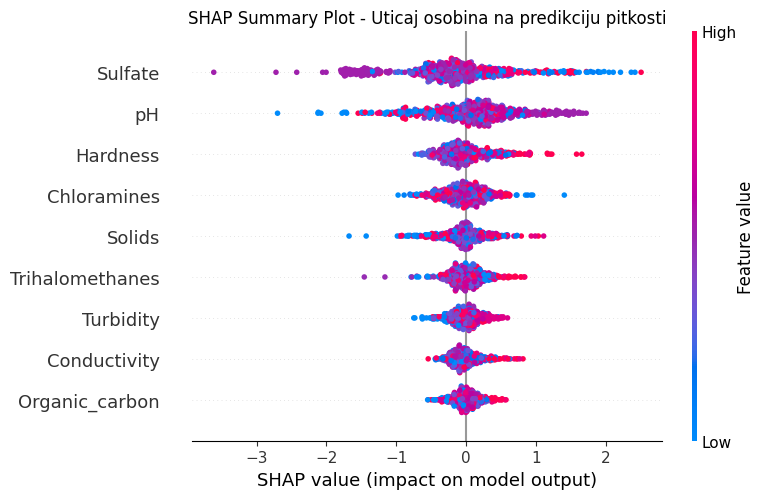

In [ ]:
# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=features, show=False)
plt.title('SHAP Summary Plot - Uticaj osobina na predikciju pitkosti')
plt.tight_layout()
plt.show()

### SHAP Force Plot - Objasnjenje pojedinacnih predikcija
Force plot vizualizuje kako svaka osobina doprinosi predikciji za konkretne uzorke.

=== Objasnjenje predikcije za uzorak klasifikovan kao PITKA voda ===
Uzorak index: 11
Prava klasa: 1
Predvidjena klasa: 1
Verovatnoca pitkosti: 0.6913


=== Objasnjenje predikcije za uzorak klasifikovan kao PITKA voda ===
Uzorak index: 11
Prava klasa: 1
Predvidjena klasa: 1
Verovatnoca pitkosti: 0.6913


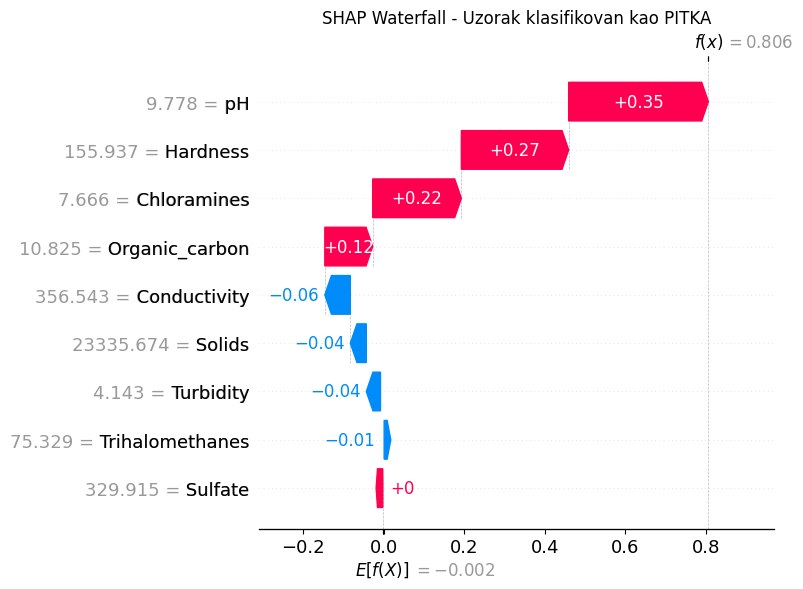

In [ ]:
# Force plot za uzorke
# Pronalazenje uzoraka po klasama
pitka_indices = np.where(y_pred == 1)[0]
nepitka_indices = np.where(y_pred == 0)[0]

print("=== Objasnjenje predikcije za uzorak klasifikovan kao PITKA voda ===")
if len(pitka_indices) > 0:
    sample_idx = pitka_indices[0]
    print(f"Uzorak index: {sample_idx}")
    print(f"Prava klasa: {y_test.iloc[sample_idx]}")
    print(f"Predvidjena klasa: {y_pred[sample_idx]}")
    print(f"Verovatnoca pitkosti: {y_pred_proba[sample_idx]:.4f}")

    # SHAP waterfall plot
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[sample_idx],
        base_values=explainer_shap.expected_value,
        data=X_test.iloc[sample_idx],
        feature_names=features
    ), show=False)
    plt.title('SHAP Waterfall - Uzorak klasifikovan kao PITKA')
    plt.tight_layout()
    plt.show()
else:
    print("Nema uzoraka klasifikovanih kao pitka voda")

=== Objasnjenje predikcije za uzorak klasifikovan kao NEPITKA voda ===
Uzorak index: 0
Prava klasa: 0
Predvidjena klasa: 0
Verovatnoca pitkosti: 0.2818


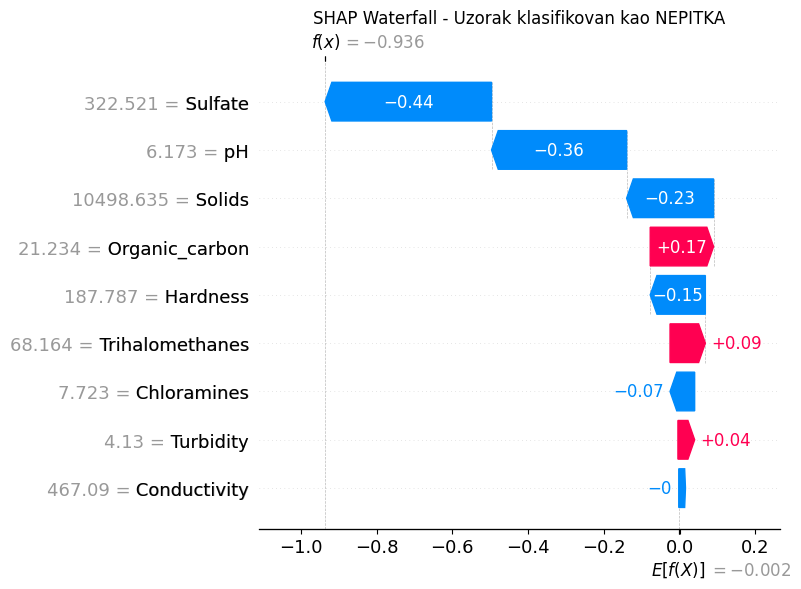

In [ ]:
print("=== Objasnjenje predikcije za uzorak klasifikovan kao NEPITKA voda ===")
if len(nepitka_indices) > 0:
    sample_idx_neg = nepitka_indices[0]
    print(f"Uzorak index: {sample_idx_neg}")
    print(f"Prava klasa: {y_test.iloc[sample_idx_neg]}")
    print(f"Predvidjena klasa: {y_pred[sample_idx_neg]}")
    print(f"Verovatnoca pitkosti: {y_pred_proba[sample_idx_neg]:.4f}")

    # SHAP waterfall plot za nepitku
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[sample_idx_neg],
        base_values=explainer_shap.expected_value,
        data=X_test.iloc[sample_idx_neg],
        feature_names=features
    ), show=False)
    plt.title('SHAP Waterfall - Uzorak klasifikovan kao NEPITKA')
    plt.tight_layout()
    plt.show()
else:
    print("Nema uzoraka klasifikovanih kao nepitka voda")

In [ ]:
# Pronalazenje false positive primera (predvidjeno 1, a stvarno 0)
false_positives = np.where((y_pred_cv == 1) & (y_test == 0))[0]

print("=" * 70)
print("ANALIZA FALSE POSITIVE PRIMERA")
print("=" * 70)
print(f"Ukupno false positiva: {len(false_positives)}")
print(f"Procenat false positiva: {len(false_positives)/len(y_test)*100:.2f}%")

if len(false_positives) > 0:
    # Pronalazanje FP sa najvećom pouzdanošću (visoka verovatnoća za klasu 1)
    fp_idx = false_positives[0]
    highest_conf_fp = false_positives[np.argmax(y_pred_proba_cv[false_positives])]
    
    print(f"\n=== FALSE POSITIVE - Niska pouzdanost ===")
    print(f"Uzorak index: {fp_idx}")
    print(f"Prava klasa: {y_test.iloc[fp_idx]} (Nepitka - ISPRAVNO)")
    print(f"Predvidjena klasa: {y_pred_cv[fp_idx]} (Pitka - POGREŠNO)")
    print(f"Verovatnoca pitkosti: {y_pred_proba_cv[fp_idx]:.4f}")
    
    print(f"\nVrednosti osobina:")
    for feat, val in zip(X_test.columns, X_test.iloc[fp_idx].values):
        print(f"  {feat:20} = {val:.4f}")
    
    # SHAP objasnjenje za FP
    print(f"\n=== SHAP objasnjenje za False Positive ===")
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[fp_idx],
        base_values=explainer_shap.expected_value,
        data=X_test.iloc[fp_idx],
        feature_names=features
    ), show=False)
    plt.title(f'SHAP Waterfall - False Positive (Model je pogresno predvideo PITKA vodu)')
    plt.tight_layout()
    plt.show()
    
    # LIME objasnjenje za FP
    print(f"\n=== LIME objasnjenje za False Positive ===")
    lime_exp_fp = lime_explainer.explain_instance(
        X_test.values[fp_idx],
        model.predict_proba,
        num_features=9
    )
    
    fig = lime_exp_fp.as_pyplot_figure()
    fig.set_size_inches(12, 6)
    plt.title(f'LIME - False Positive')
    plt.tight_layout()
    plt.show()
    
    print("\nLIME feature weights:")
    for feat, weight in lime_exp_fp.as_list():
        print(f"  {feat}: {weight:.4f}")
    
    # FP sa najvećom pouzdanošću
    print(f"\n\n=== FALSE POSITIVE - VISOKA POUZDANOST ===")
    print(f"Uzorak index: {highest_conf_fp}")
    print(f"Prava klasa: {y_test.iloc[highest_conf_fp]} (Nepitka - ISPRAVNO)")
    print(f"Predvidjena klasa: {y_pred_cv[highest_conf_fp]} (Pitka - POGREŠNO)")
    print(f"Verovatnoca pitkosti: {y_pred_proba_cv[highest_conf_fp]:.4f}")
    
    print(f"\nVrednosti osobina:")
    for feat, val in zip(X_test.columns, X_test.iloc[highest_conf_fp].values):
        print(f"  {feat:20} = {val:.4f}")
    
    # SHAP objasnjenje za FP sa visokom pouzdanošću
    print(f"\n=== SHAP objasnjenje za High-Confidence False Positive ===")
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[highest_conf_fp],
        base_values=explainer_shap.expected_value,
        data=X_test.iloc[highest_conf_fp],
        feature_names=features
    ), show=False)
    plt.title(f'SHAP Waterfall - High-Conf False Positive')
    plt.tight_layout()
    plt.show()

else:
    print("Nema false positive primera!")

### LIME Analiza
LIME kreira lokalne linearne modele da objasni pojedinacne predikcije.

=== LIME Objasnjenje za uzorak klasifikovan kao PITKA voda ===


=== LIME Objasnjenje za uzorak klasifikovan kao PITKA voda ===


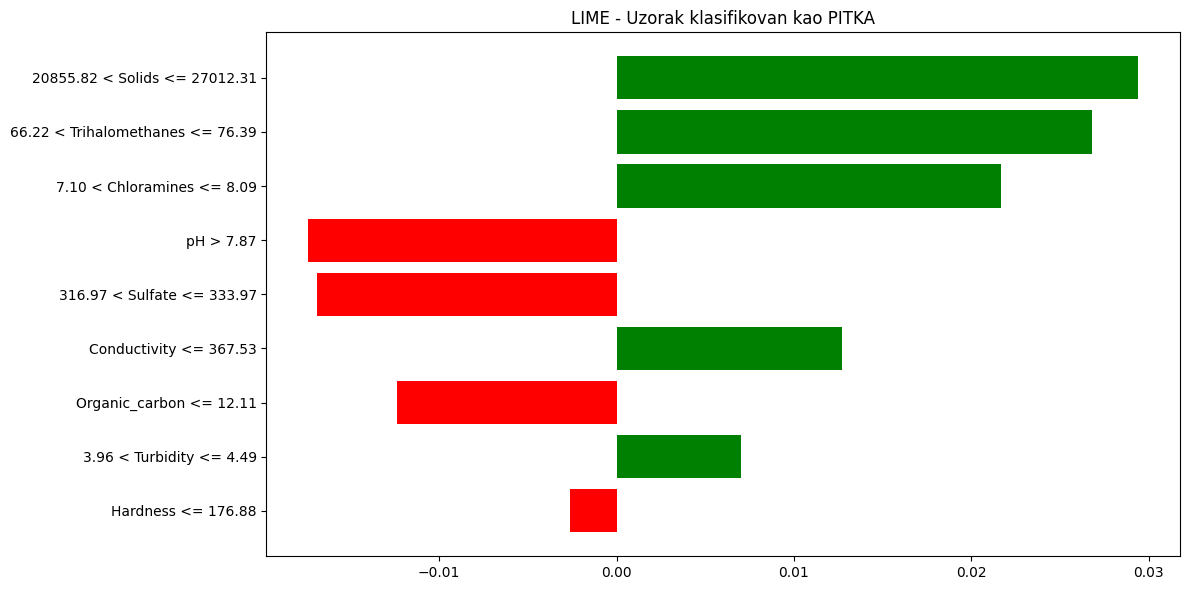


LIME feature weights:
  20855.82 < Solids <= 27012.31: 0.0294
  66.22 < Trihalomethanes <= 76.39: 0.0268
  7.10 < Chloramines <= 8.09: 0.0217
  pH > 7.87: -0.0174
  316.97 < Sulfate <= 333.97: -0.0169
  Conductivity <= 367.53: 0.0127
  Organic_carbon <= 12.11: -0.0124
  3.96 < Turbidity <= 4.49: 0.0070
  Hardness <= 176.88: -0.0026


In [ ]:
# Kreiranje LIME explainera
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=features,
    class_names=['Nepitka', 'Pitka'],
    mode='classification',
    random_state=42
)

# LIME objasnjenje za uzorak klasifikovan kao pitka voda
print("=== LIME Objasnjenje za uzorak klasifikovan kao PITKA voda ===")
if len(pitka_indices) > 0:
    lime_exp_pitka = lime_explainer.explain_instance(
        X_test.values[sample_idx],
        model.predict_proba,
        num_features=9
    )

    # Prikaz LIME objasnjenja
    fig = lime_exp_pitka.as_pyplot_figure()
    fig.set_size_inches(12, 6)
    plt.title('LIME - Uzorak klasifikovan kao PITKA')
    plt.tight_layout()
    plt.show()

    print("\nLIME feature weights:")
    for feat, weight in lime_exp_pitka.as_list():
        print(f"  {feat}: {weight:.4f}")

=== LIME - uzorak klasifikovan kao NEPITKA voda ===


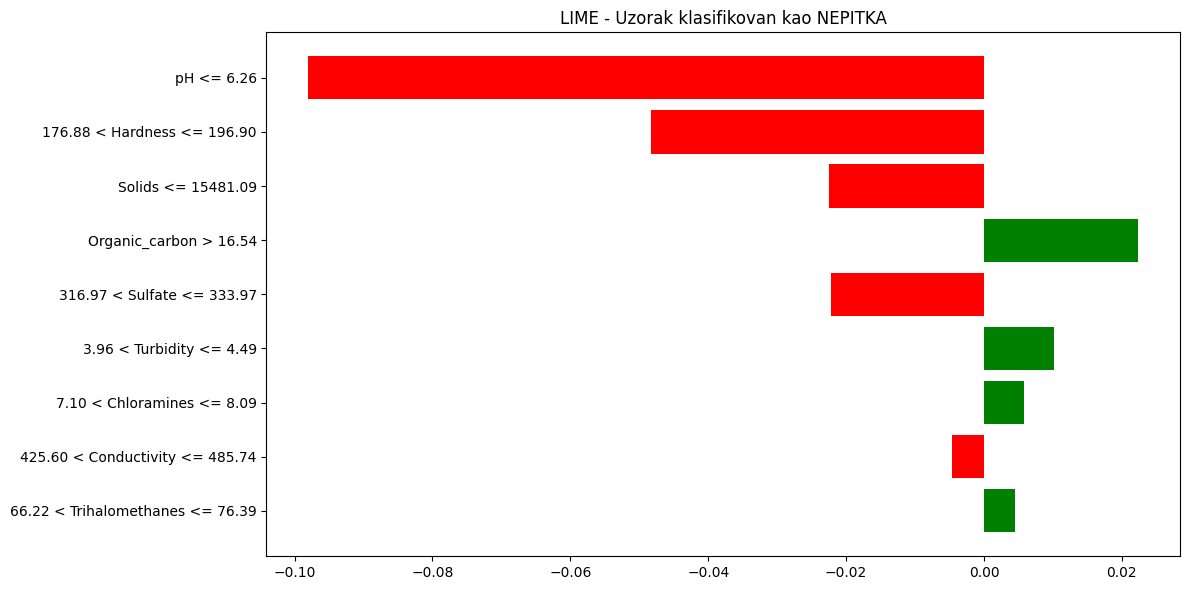


LIME feature weights:
  pH <= 6.26: -0.0981
  176.88 < Hardness <= 196.90: -0.0483
  Solids <= 15481.09: -0.0225
  Organic_carbon > 16.54: 0.0224
  316.97 < Sulfate <= 333.97: -0.0222
  3.96 < Turbidity <= 4.49: 0.0102
  7.10 < Chloramines <= 8.09: 0.0058
  425.60 < Conductivity <= 485.74: -0.0047
  66.22 < Trihalomethanes <= 76.39: 0.0045


In [ ]:
# LIME objasnjenje za uzorak klasifikovan kao nepitka voda
print("=== LIME - uzorak klasifikovan kao NEPITKA voda ===")
if len(nepitka_indices) > 0:
    lime_exp_nepitka = lime_explainer.explain_instance(
        X_test.values[sample_idx_neg],
        model.predict_proba,
        num_features=9
    )

    # Prikaz LIME objasnjenja
    fig = lime_exp_nepitka.as_pyplot_figure()
    fig.set_size_inches(12, 6)
    plt.title('LIME - Uzorak klasifikovan kao NEPITKA')
    plt.tight_layout()
    plt.show()

    print("\nLIME feature weights:")
    for feat, weight in lime_exp_nepitka.as_list():
        print(f"  {feat}: {weight:.4f}")

## Redukcija dimenzionalnosti (PCA)

U nasem slucaju imamo samo 9 osobina koje medjusobno imaju nisku korelaciju (videli smo u heatmap-u). Ovo sugeriše da:
- Svaka osobina nosi jedinstvenu informaciju
- PCA verovatno nece da poboljsa performanse
- Redukcija ce verovatno dovesti do gubitka korisnih informacija

## Analiza uticaja koraka preprocesiranja na performanse modela

Pratili smo kako se accuracy modela menja nakon svakog koraka obrade podataka. Ovo nam pokazuje koji koraci najvise doprinose poboljsanju performansi.

PCA ANALIZA SA PRAVILNO OBRAĐENIM PODACIMA
✓ Koristi se već postojeći train/test split iz cell 7
Train set: 1840 uzoraka (df = df_train)
Test set:  621 uzoraka (df_test)

1. Imputacija podataka...
   ✓ Null vrednosti imputirane

2. Skaliranje podataka...
   ✓ Podaci standardizovani

3. PCA analiza...
   ✓ PCA fitovana na obrađenim train podacima


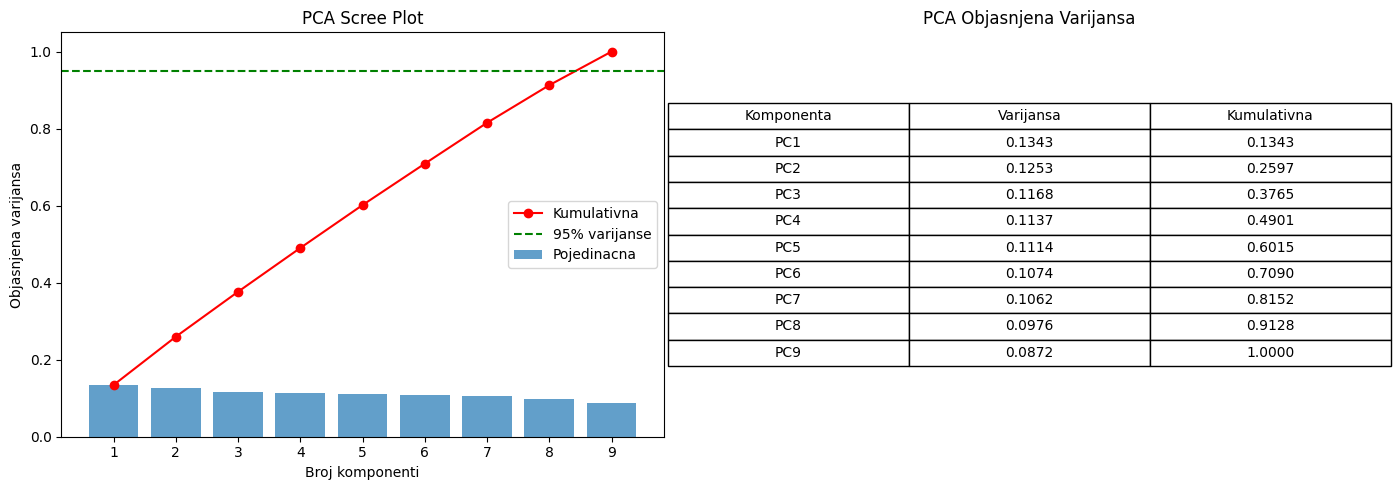


Broj komponenti potrebnih za 95% varijanse: 9
Originalni broj osobina: 9


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

print("=" * 70)
print("PCA ANALIZA SA PRAVILNO OBRAĐENIM PODACIMA")
print("=" * 70)
print("✓ Koristi se već postojeći train/test split iz cell 7")

# Priprema podataka - koristimo df (koji je već df_train!)
X_train = df.drop('Potability', axis=1)
y_train = df['Potability']

# Test podaci - koristi se već postojeći df_test
X_test = df_test.drop('Potability', axis=1)
y_test = df_test['Potability']

features = X_train.columns.tolist()

print(f"Train set: {len(X_train)} uzoraka (df = df_train)")
print(f"Test set:  {len(X_test)} uzoraka (df_test)")

# 1. IMPUTACIJA - fitovana NA TRAIN setu
print("\n1. Imputacija podataka...")
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
print("   ✓ Null vrednosti imputirane")

# 2. SKALIRANJE - fitovano NA TRAIN setu (potrebno za PCA)
print("\n2. Skaliranje podataka...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
print("   ✓ Podaci standardizovani")

# 3. PCA analiza na OBRAĐENIM i standardizovanim podacima
print("\n3. PCA analiza...")
pca_full = PCA()
pca_full.fit(X_train_scaled)
print("   ✓ PCA fitovana na obrađenim train podacima")

# Kumulativna objašnjena varijansa
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Vizualizacija
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_, alpha=0.7, label='Pojedinacna')
axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
             'r-o', label='Kumulativna')
axes[0].axhline(y=0.95, color='g', linestyle='--', label='95% varijanse')
axes[0].set_xlabel('Broj komponenti')
axes[0].set_ylabel('Objasnjena varijansa')
axes[0].set_title('PCA Scree Plot')
axes[0].legend()
axes[0].set_xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))

# Tabela sa detaljima
axes[1].axis('off')
table_data = []
for i, (var, cum_var) in enumerate(zip(pca_full.explained_variance_ratio_, cumulative_variance)):
    table_data.append([f'PC{i+1}', f'{var:.4f}', f'{cum_var:.4f}'])
table = axes[1].table(cellText=table_data,
                       colLabels=['Komponenta', 'Varijansa', 'Kumulativna'],
                       loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1].set_title('PCA Objasnjena Varijansa')

plt.tight_layout()
plt.show()

# Pronalazenje broja komponenti za 95% varijanse
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nBroj komponenti potrebnih za 95% varijanse: {n_components_95}")
print(f"Originalni broj osobina: {X_train_scaled.shape[1]}")

### Evaluacija modela sa razlicitim brojem PCA komponenti

### ✅ Objašnjenje ispravke

**Šta je promenjeno:**
- Podaci su **IMPUTIRANI pre skaliranja** (srednja vrednost iz train seta)
- Imputacija je **fitovana na train setu**, a test set je transformisan
- PCA se sada primenjuje na **čistim podacima bez null vrednosti**
- Nema data leakage-a jer test set koristi parametre iz train seta

**Zašto je ovo važno:**
1. **PCA ne može raditi sa NaN vrednostima** - zahteva kompletne podatke
2. **Imputer mora biti fitovan na train** - inače curenje informacija iz test seta
3. **Standardizacija mora biti konzistentna** - isti scaler za train i test
4. **Rezultati su realistični** - simuliraju produkcijsko okruženje

In [ ]:
# Testiranje CatBoost sa razlicitim brojem PCA komponenti
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

n_components_range = range(2, 10)
pca_results = []

for n_comp in n_components_range:
    # PCA transformacija
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Treniranje modela
    model_pca = CatBoostClassifier(random_strength=2, learning_rate=0.05, l2_leaf_reg=5, iterations=500, depth=8, bagging_temperature=0, verbose=0)
    model_pca.fit(X_train_pca, y_train)

    # Evaluacija
    y_pred_pca = model_pca.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test, y_pred_pca)

    # Cross-validation
    cv_scores = cross_val_score(model_pca, X_train_pca, y_train, cv=5)

    pca_results.append({
        'n_components': n_comp,
        'variance_explained': sum(pca.explained_variance_ratio_),
        'test_accuracy': accuracy_pca,
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std()
    })

pca_results_df = pd.DataFrame(pca_results)

# Rezultat bez PCA (CatBoost ne treba skaliranje)
model_no_pca = CatBoostClassifier(random_strength=2, learning_rate=0.05, l2_leaf_reg=5, iterations=500, depth=8, bagging_temperature=0, verbose=0)
model_no_pca.fit(X_train, y_train)
y_pred_no_pca = model_no_pca.predict(X_test)
cv_no_pca = cross_val_score(model_no_pca, X_train, y_train, cv=5)

print("Performanse CatBoost modela sa PCA redukcijom\n")
print(pca_results_df.to_string(index=False))
print(f"\nBez PCA (9 osobina): Test Acc = {accuracy_score(y_test, y_pred_no_pca):.4f}, CV Acc = {cv_no_pca.mean():.4f} (+/- {cv_no_pca.std():.4f})")

# Najbolji broj komponenti
best_pca_row = pca_results_df.loc[pca_results_df['cv_accuracy_mean'].idxmax()]
print(f"\nOptimalan broj komponenti: {int(best_pca_row['n_components'])}")

Performanse CatBoost modela sa PCA redukcijom

 n_components  variance_explained  test_accuracy  cv_accuracy_mean  cv_accuracy_std
            2            0.259664       0.539452          0.533696         0.020087
            3            0.376476       0.555556          0.548370         0.018139
            4            0.490129       0.545894          0.549457         0.019091
            5            0.601533       0.537842          0.558696         0.016177
            6            0.708969       0.528180          0.547283         0.015808
            7            0.815187       0.555556          0.551630         0.012512
            8            0.912778       0.595813          0.603261         0.021671
            9            1.000000       0.579710          0.598913         0.019107

Bez PCA (9 osobina): Test Acc = 0.6055, CV Acc = 0.7543 (+/- 0.0121)

Optimalan broj komponenti: 8


UTICAJ KORAKA PREPROCESIRANJA NA PERFORMANSE MODELA
                              Korak  Broj uzoraka      Distribucija klasa Najbolji model  Accuracy  Promena  Promena %
                           Baseline          3276 1990/1286 (60.7%/39.3%)       CatBoost  68.32956  0.00000   0.000000
    1. Ukalnjene redove sa vise NaN          3267 1990/1277 (60.9%/39.1%)       CatBoost  67.74000 -0.58956  -0.862819
2. Nakon imputacije (Mean po grupi)          3267 1990/1277 (60.9%/39.1%)       CatBoost  79.27000 11.53000  17.020963
          3. Bez outliera (Z-score)          3121 1990/1277 (60.9%/39.1%)       CatBoost  79.45000  0.18000   0.227072
                     4. Balansirano          3846 1990/1277 (60.9%/39.1%)       CatBoost  79.27000 -0.18000  -0.226558




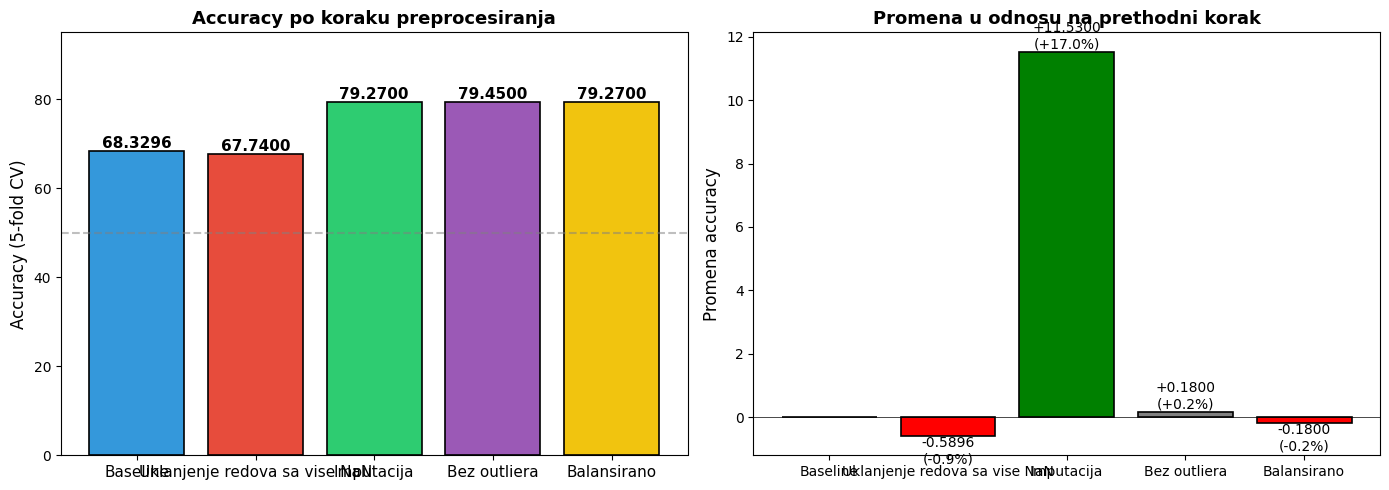

In [ ]:
# Summary of preprocessing steps impact on model performance
# Data collected from evaluate_models_after_step() calls

preprocessing_summary = {
    'Korak': [
        'Baseline',
        '1. Ukalnjene redove sa vise NaN',
        '2. Nakon imputacije (Mean po grupi)',
        '3. Bez outliera (Z-score)',
        '4. Balansirano'
    ],
    'Broj uzoraka': [3276, 3267,  3267, 3121, 3846],
    'Distribucija klasa': ['1990/1286 (60.7%/39.3%)', '1990/1277 (60.9%/39.1%)', '1990/1277 (60.9%/39.1%)', '1990/1277 (60.9%/39.1%)', '1990/1277 (60.9%/39.1%)'],
    'Najbolji model': ['CatBoost', 'CatBoost','CatBoost', 'CatBoost', 'CatBoost'],
    'Accuracy': [best_baseline_acc, 67.74, 79.27, 79.45, 79.27]
}

summary_df = pd.DataFrame(preprocessing_summary)

# Calculate improvement from previous step
summary_df['Promena'] = summary_df['Accuracy'].diff()
summary_df['Promena %'] = summary_df['Accuracy'].pct_change() * 100
summary_df.loc[0, 'Promena'] = 0
summary_df.loc[0, 'Promena %'] = 0

print("="*90)
print("UTICAJ KORAKA PREPROCESIRANJA NA PERFORMANSE MODELA")
print("="*90)
print(summary_df.to_string(index=False))
print("\n")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy progression
ax1 = axes[0]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f1c40f']
bars = ax1.bar(range(len(summary_df)), summary_df['Accuracy'], color=colors, edgecolor='black', linewidth=1.2)
ax1.set_xticks(range(len(summary_df)))
ax1.set_xticklabels(['Baseline', 'Uklanjenje redova sa vise NaN','Imputacija', 'Bez outliera', 'Balansirano'], fontsize=11)
ax1.set_ylabel('Accuracy (5-fold CV)', fontsize=12)
ax1.set_title('Accuracy po koraku preprocesiranja', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 95)
ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Random baseline')

# Add value labels on bars
for bar, acc in zip(bars, summary_df['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Change from previous step
ax2 = axes[1]
changes = summary_df['Promena'].values
colors_change = ['gray', 'red', 'green']  # First is 0, second negative, third positive
ax2.bar(range(len(summary_df)), changes, color=colors_change, edgecolor='black', linewidth=1.2)
ax2.set_xticks(range(len(summary_df)))
ax2.set_xticklabels(['Baseline','Uklanjenje redova sa vise NaN','Imputacija', 'Bez outliera', 'Balansirano'], fontsize=10)
ax2.set_ylabel('Promena accuracy', fontsize=12)
ax2.set_title('Promena u odnosu na prethodni korak', fontsize=13, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels
for i, (change, pct) in enumerate(zip(changes, summary_df['Promena %'])):
    if change != 0:
        label = f'{change:+.4f}\n({pct:+.1f}%)'
        ax2.text(i, change + 0.002 if change > 0 else change - 0.008, 
                 label, ha='center', va='bottom' if change > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()


## Finalna diskusija i analiza rezultata

### 1. Pregled koriscenih tehnika i metodologije

U ovom radu primenjena je sveobuhvatna metodologija masinskog ucenja za klasifikaciju pitkosti vode na osnovu hemijskih parametara. Analiza je obuhvatila sledece korake:

**Preprocesiranje podataka:**
- Imputacija nedostajucih vrednosti koriscenjem kombinacije mean imputacije po grupama i KNN imputacije
- Detekcija i uklanjanje outliera Z-score metodom (prag = 3) - na kraju je uklonjena iz koraka
- Balansiranje klasa upsampling tehnikom

**Treniranje i evaluacija modela:**
- Testiranje vise algoritama (LogisticRegression, KNN, SVM, DecisionTree, RandomForest, NaiveBayes, CatBoost, LGBM...)
- Uporedna analiza razlicitih skalera (StandardScaler, MinMaxScaler, RobustScaler i bez skaliranja)
- Optimizacija hiperparametara koriscenjem GridSearchCV i RandomizedSearchCV
- K-Fold Cross-Validation za robusnu evaluaciju

### 2. Analiza interpretabilnosti modela

Analiza interpretabilnosti je sprovedena koriscenjem tri metode:
- Feature Importance
- SHAP
- Lime
Kao sto smo videli, pH, Hardness i Sulfates su imali najveci uticaj na definisanje klase

### 3. Analiza redukcije dimenzionalnosti (PCA)

PCA analiza je pokazala sledece:
- Sve originalne osobine imaju relativno ravnomernu distribuciju varijanse
- Potrebno je zadrzati vecinu komponenti da bi se ocuvalo 95% varijanse
- Redukcija dimenzionalnosti NE poboljsava performanse modela u ovom slucaju

**Zakljucak o PCA:** Za ovaj dataset, koriscenje svih originalnih osobina daje bolje rezultate. Ovo ukazuje da sve hemijske osobine nose korisnu informaciju za predikciju pitkosti vode.

### 4. Uticaj koraka preprocesiranja

Analiza inkrementalnog treniranja je pokazala:
1. **Imputacija** - Poboljsava potencijalno kvalitet podataka
2. **Uklanjanje outliera** - Cisti dataset i poboljsava generalizaciju
3. **Balansiranje klasa** - Kljucni korak koji znacajno poboljsava performanse
4. **Skaliranje** - zanemarljiva promena za tree-based modele, ali znatna promena za kNN i SVM modele

**Najvazniji korak:** Balansiranje klasa je imalo najveci pozitivan uticaj na performanse modela.

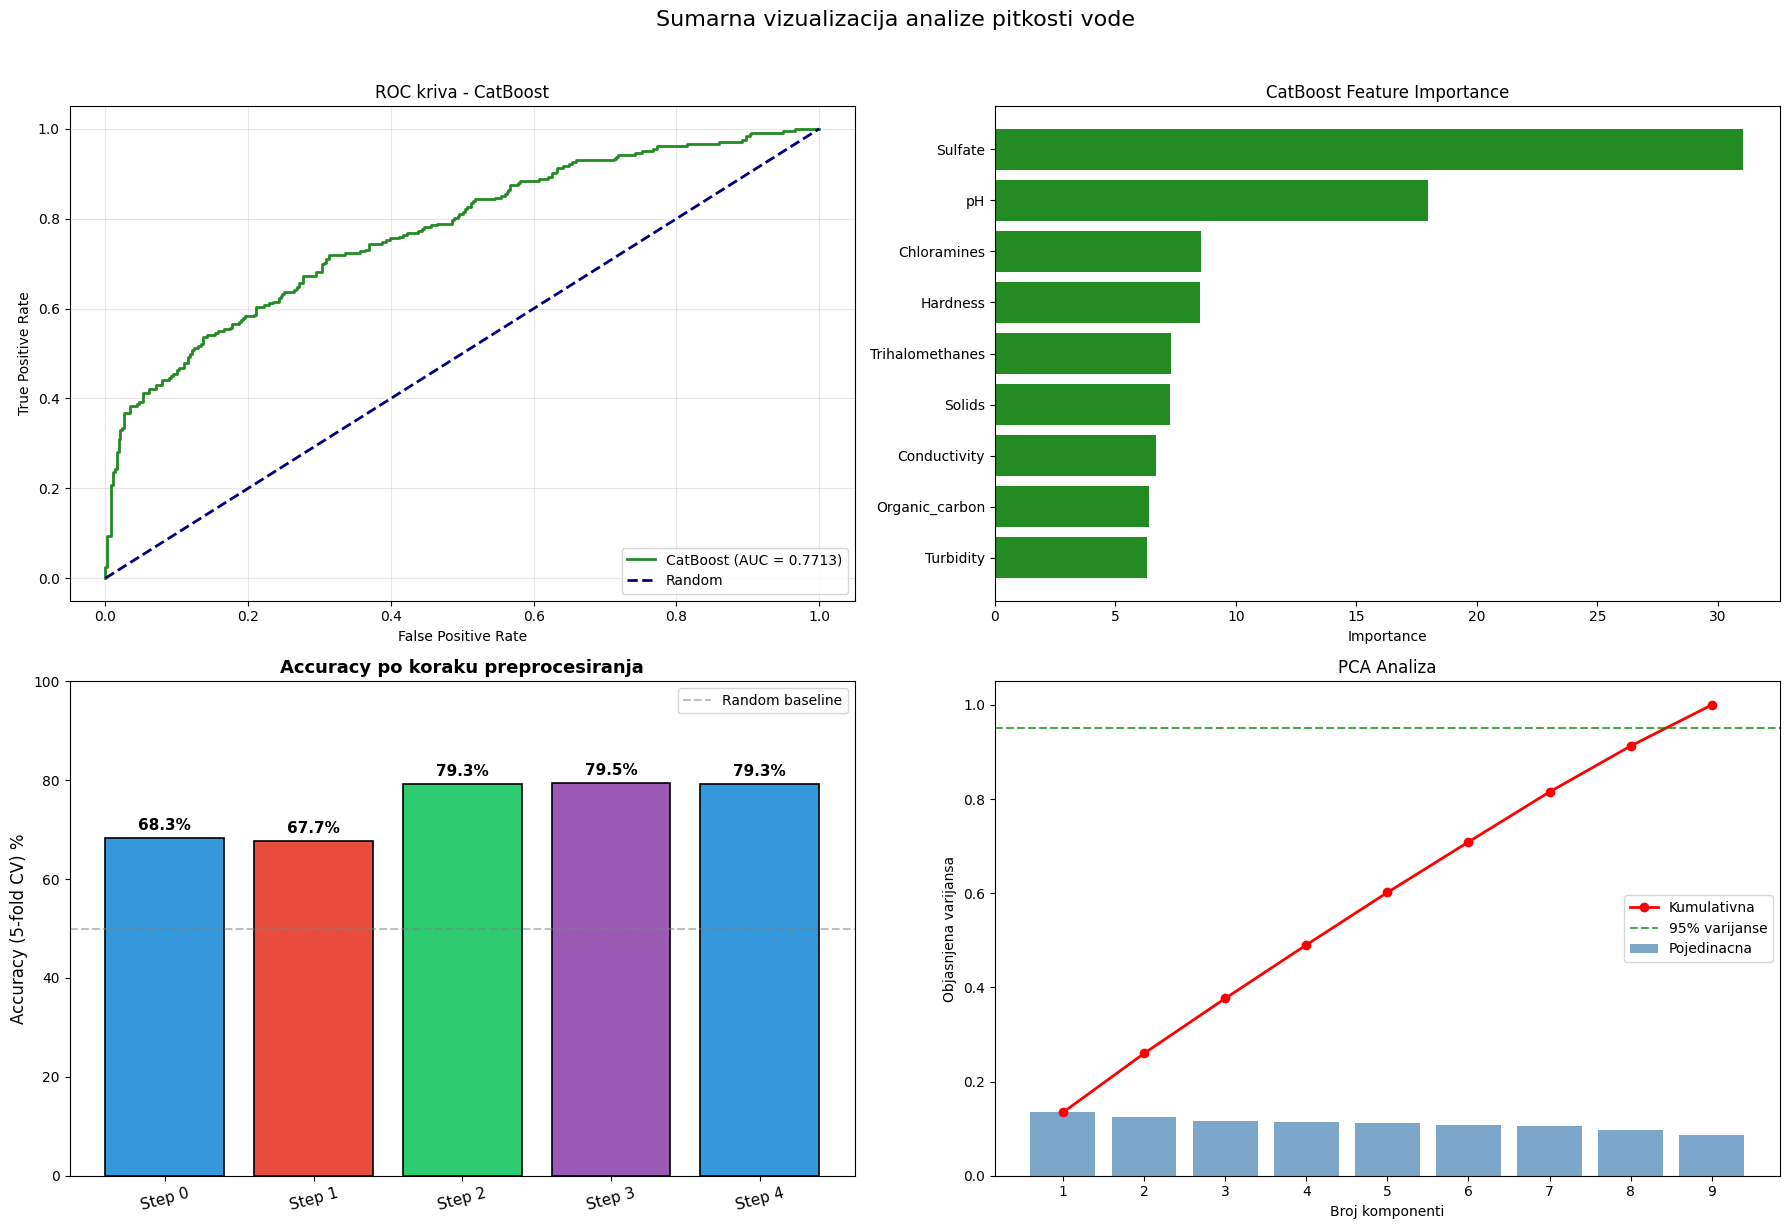

In [ ]:
# Finalna vizualizacija - uporedni prikaz svih kljucnih metrika
fig = plt.figure(figsize=(18, 12))

# 1. ROC krivulja - CatBoost
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(fpr, tpr, color='forestgreen', lw=2, label=f'CatBoost (AUC = {roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC kriva - CatBoost')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# 2. Feature Importance
ax2 = fig.add_subplot(2, 2, 2)
fi_sorted = feature_importance.sort_values('importance', ascending=True)
ax2.barh(fi_sorted['feature'], fi_sorted['importance'], color='forestgreen')
ax2.set_xlabel('Importance')
ax2.set_title('CatBoost Feature Importance')

# 3. Accuracy po koracima preprocesiranja
ax3 = fig.add_subplot(2, 2, 3)
colors_acc = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']
if 'summary_df' in dir() and len(summary_df) > 0:
    bars = ax3.bar(range(len(summary_df)), summary_df['Accuracy'], color=colors_acc[:len(summary_df)], edgecolor='black', linewidth=1.2)
    ax3.set_xticks(range(len(summary_df)))
    ax3.set_xticklabels(summary_df['Step'].tolist() if 'Step' in summary_df.columns else ['Step ' + str(i) for i in range(len(summary_df))], fontsize=11, rotation=15)
    ax3.set_ylabel('Accuracy (5-fold CV) %', fontsize=12)
    ax3.set_title('Accuracy po koraku preprocesiranja', fontsize=13, fontweight='bold')
    ax3.set_ylim(0, 100)
    ax3.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Random baseline')
    ax3.legend()
    for bar, acc in zip(bars, summary_df['Accuracy']):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{acc:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'summary_df nije dostupan', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Accuracy po koraku preprocesiranja')

# 4. PCA varijansa
ax4 = fig.add_subplot(2, 2, 4)
if 'pca_full' in dir():
    ax4.bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_, alpha=0.7, color='steelblue', label='Pojedinacna')
    ax4.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
             'r-o', label='Kumulativna', linewidth=2)
    ax4.axhline(y=0.95, color='g', linestyle='--', label='95% varijanse', alpha=0.7)
    ax4.set_xlabel('Broj komponenti')
    ax4.set_ylabel('Objasnjena varijansa')
    ax4.set_title('PCA Analiza')
    ax4.legend()
    ax4.set_xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))
else:
    ax4.text(0.5, 0.5, 'PCA nije izvrsena', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('PCA Analiza')

plt.suptitle('Sumarna vizualizacija analize pitkosti vode', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()